# Navier-Stokes Equation

Imports

In [1]:
%load_ext autoreload
%autoreload 2

import sys

module_dir = '../'

if module_dir not in sys.path:
    sys.path.append(module_dir)

import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
from models import *
import test_systems_1d as systems_1d
import itertools
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import NoNorm
from matplotlib.colors import Normalize
from tqdm import tqdm
import gpjax as gpx
from sklearn.decomposition import PCA
import scipy.io
from scipy.interpolate import griddata

from jax import config
config.update("jax_enable_x64", True)

/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load data

In [2]:
x = np.load('../navier_stokes_data/NavierStokes_inputs.npy').transpose((2,1,0)).reshape(40000, 64*64)
y = np.load('../navier_stokes_data/NavierStokes_outputs.npy').transpose((2,1,0)).reshape(40000, 64*64)

x_train = x[int(len(x)/5):, :]
y_train = y[int(len(y)/5):, :]

x_test = x[:int(len(x)/5), :]
y_test = y[:int(len(y)/5), :]

print(x.shape, y.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

x_train = x_train[:1000, :]
y_train = y_train[:1000, :]

x_test = x_test[:1000, :]
y_test = y_test[:1000, :]

(40000, 4096) (40000, 4096)
(32000, 4096) (32000, 4096)
(8000, 4096) (8000, 4096)


Visualise input and output data

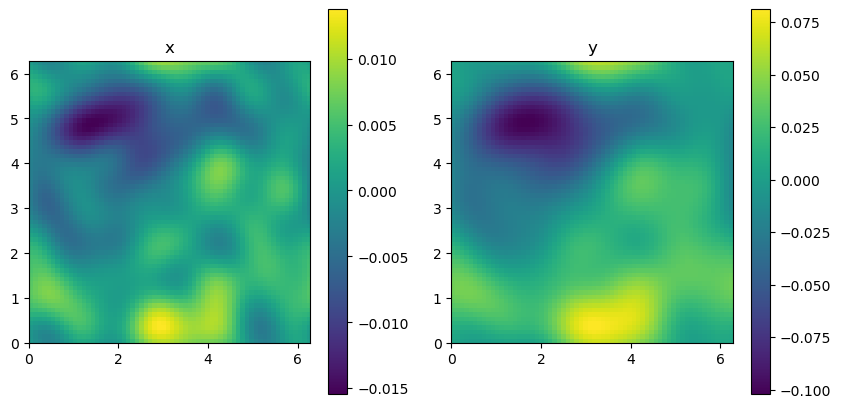

In [3]:
index_to_plot = 12

# print(len(x_train), x_train.shape, x_train[1].shape, y_train.shape)
# print(len(x_test), x_test.shape, x_test[1].shape, y_test.shape)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
im0 = ax[0].imshow(x_train[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi])
ax[0].set_title("x")
im1 = ax[1].imshow(y_train[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi])
ax[1].set_title("y")
fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])
plt.show()

Define model

In [4]:
import sys
module_dir = '../'
if module_dir not in sys.path:
    sys.path.append(module_dir)
from models import *
import gpjax as gpx

class full_model():
    def __init__(self, n, m, ARD, multiinput, standardise, combine_pca):
        # if combining pca, the dimension of the latent space = n
        self.n = n
        self.m = m
        self.ARD = ARD
        self.multiinput = multiinput
        self.standardise = standardise
        self.combine_pca = combine_pca
        if self.combine_pca:
            self.m = self.n

    def fit(self, x_train, y_train, n_samples = None):

        if self.ARD:
            ls = jnp.full(self.n, 2, dtype=jnp.float64)
            var = jnp.full(self.n, 2, dtype=jnp.float64)
        else:
            ls = jnp.full((1), 2, dtype=jnp.float64)
            var = jnp.full((1), 2, dtype=jnp.float64)

        GP_params = {"kernel": gpx.kernels.RBF(lengthscale = ls, variance = jnp.full((1), 1, dtype=jnp.float64)), 'mean_function': gpx.mean_functions.Zero(), 'multiinput': self.multiinput}

        self.x_train = x_train
        self.y_train = y_train

        if self.m is None:
            self.m = self.y_train.shape[-1]

        if self.combine_pca:
            self.combined_pca = PCA(n_components = self.n)
            self.combined_train = np.concatenate((self.x_train, self.y_train), axis = 1)
            self.combined_train_pca = self.combined_pca.fit_transform(self.combined_train)
            print('does combined pca')
            
            self.x_pca = PCA(n_components = self.n)
            self.y_pca = PCA(n_components = self.n)
            self.x_pca.components_ = self.combined_pca.components_[:, :4096]
            self.x_pca.mean_ = self.combined_pca.mean_[:4096]
            self.y_pca.components_ = self.combined_pca.components_[:, 4096:]
            self.y_pca.mean_ = self.combined_pca.mean_[4096:]

            self.x_train_pca = self.x_pca.transform(self.x_train)
            print('does x pca')
            self.y_train_pca = self.y_pca.transform(self.y_train)
            print('does y pca')

        else:
            self.x_pca = PCA(n_components = self.n)
            self.y_pca = PCA(n_components = self.m)
            self.x_train_pca = self.x_pca.fit_transform(self.x_train)
            print('does x pca')
            self.y_train_pca = self.y_pca.fit_transform(self.y_train)
            print('does y pca')

        self.model_list = []

        if n_samples is not None:
            train_samples_pca = np.zeros((x_train.shape[0], self.m, n_samples))
            train_samples = np.zeros((self.y_train.shape[0], self.y_train.shape[1], n_samples))

        if self.standardise:
            self.x_train_pca_stand = (self.x_train_pca - self.x_train_pca.mean(axis = 0))/self.x_train_pca.std(axis = 0)
            self.y_train_pca_stand = (self.y_train_pca - self.y_train_pca.mean(axis = 0))/self.y_train_pca.std(axis = 0)

            if self.multiinput:
                for i in tqdm(range(self.y_train_pca_stand.shape[-1])):
                    local_gp = GP_regressor(GP_params=GP_params)
                    local_gp.fit(self.x_train_pca_stand, self.y_train_pca_stand[:, i])
                    print(local_gp.kernel.lengthscale)
                    print(local_gp.kernel.variance)
                    self.model_list.append(local_gp)
                    if n_samples is not None:
                        train_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_train_pca_stand, n_samples = n_samples)
            
            else:
                for i in tqdm(range(self.y_train_pca_stand.shape[-1])):
                    local_gp = GP_regressor(GP_params=GP_params)
                    local_gp.fit(self.x_train_pca_stand[:, i].reshape(-1, 1), self.y_train_pca_stand[:, i])
                    self.model_list.append(local_gp)
                    if n_samples is not None:
                        train_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_train_pca_stand[:, i].reshape(-1, 1), n_samples = n_samples)

        else:
            if self.multiinput:
                for i in tqdm(range(self.y_train_pca.shape[-1])):
                    local_gp = GP_regressor(GP_params=GP_params)
                    local_gp.fit(self.x_train_pca, self.y_train_pca[:, i])
                    self.model_list.append(local_gp)
                    if n_samples is not None:
                        train_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_train_pca, n_samples = n_samples)
            
            else:
                for i in tqdm(range(self.y_train_pca.shape[-1])):
                    local_gp = GP_regressor(GP_params=GP_params)
                    local_gp.fit(self.x_train_pca[:, i].reshape(-1, 1), self.y_train_pca[:, i])
                    self.model_list.append(local_gp)
                    if n_samples is not None:
                        train_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_train_pca[:, i].reshape(-1, 1), n_samples = n_samples)

        if n_samples is not None:
            for i in range(n_samples):
                train_samples_pca_i = train_samples_pca[:, :, i]
                train_samples_i = self.y_pca.inverse_transform(train_samples_pca_i)
                train_samples[:, :, i] = train_samples_i
            return train_samples
    
    def predict(self, x_test, n_samples = None):

        self.x_test = x_test

        self.x_test_pca = self.x_pca.transform(x_test)

        if n_samples is not None:
            test_samples_pca = np.zeros((x_test.shape[0], self.m, n_samples))
            test_samples = np.zeros((self.x_test.shape[0], self.y_train.shape[1], n_samples))
        
        if self.standardise:
            y_pred_pca_stand = []
            self.x_test_pca_stand = (self.x_test_pca - self.x_train_pca.mean(axis = 0))/self.x_train_pca.std(axis = 0)
            if self.multiinput:
                for i in tqdm(range(self.m)):
                    local_gp = self.model_list[i]
                    y_pred_pca_stand.append(local_gp.predict(self.x_test_pca_stand, return_bounds = True))
                    if n_samples is not None:
                        test_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_test_pca_stand, n_samples = n_samples)
                        test_samples_pca[:, i, :] = (test_samples_pca[:, i, :] * self.y_train_pca.std(axis = 0)[i]) + self.y_train_pca.mean(axis = 0)[i]
            
            else:
                for i in tqdm(range(self.m)):
                    local_gp = self.model_list[i]
                    y_pred_pca_stand.append(local_gp.predict(self.x_test_pca_stand[:, i].reshape(-1, 1), return_bounds = True))
                    if n_samples is not None:
                        test_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_test_pca_stand[:, i].reshape(-1, 1), n_samples = n_samples)
                        test_samples_pca[:, i, :] = (test_samples_pca[:, i, :] * self.y_train_pca.std(axis = 0)[i]) + self.y_train_pca.mean(axis = 0)[i]
            
            y_pred_pca_stand = np.stack(y_pred_pca_stand).T
            self.y_pred_pca = (y_pred_pca_stand * self.y_train_pca.std(axis = 0)) + self.y_train_pca.mean(axis = 0)
        
        else:
            self.y_pred_pca = []
            if self.multiinput:
                for i in tqdm(range(self.m)):
                    local_gp = self.model_list[i]
                    self.y_pred_pca.append(local_gp.predict(self.x_test_pca, return_bounds = True))
                    if n_samples is not None:
                        test_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_test_pca, n_samples = n_samples)
            
            else:
                for i in tqdm(range(self.m)):
                    local_gp = self.model_list[i]
                    self.y_pred_pca.append(local_gp.predict(self.x_test_pca[:, i].reshape(-1, 1), return_bounds = True))
                    if n_samples is not None:
                        test_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_test_pca[:, i].reshape(-1, 1), n_samples = n_samples)
            
            self.y_pred_pca = np.stack(self.y_pred_pca).T
        
        y_pred = self.y_pca.inverse_transform(self.y_pred_pca)

        if n_samples is not None:
            for i in range(n_samples):
                test_samples_pca_i = test_samples_pca[:, :, i]
                test_samples_i = self.y_pca.inverse_transform(test_samples_pca_i)
                test_samples[:, :, i] = test_samples_i
            return y_pred[:, 0, :], test_samples
        else:
            return y_pred[:, 0, :]

Determine the number of PCs required to capture a given amount of variance

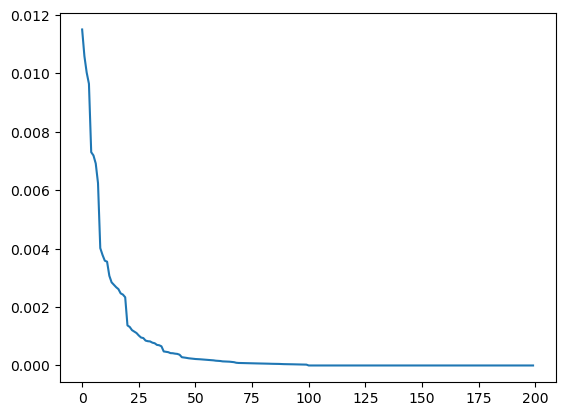

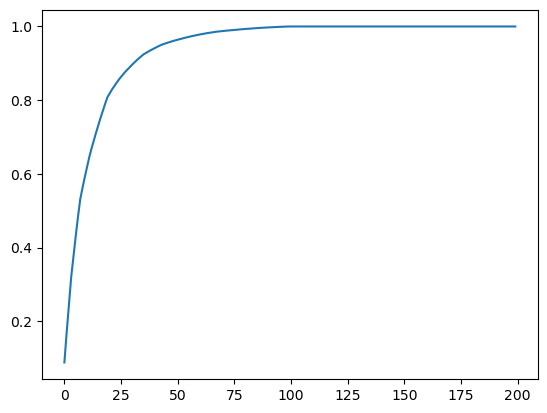

[0.08806532 0.16914671 0.24592865 0.31975153 0.37565711 0.4306989
 0.48364357 0.53144437 0.56220123 0.5911655  0.6186316  0.64583928
 0.66934926 0.69114094 0.71230003 0.7328207  0.75283948 0.77173927
 0.79032014 0.80820048 0.81870547 0.82880227 0.83806654 0.84695795
 0.85545891 0.86331605 0.87064223 0.87782419 0.88434588 0.8907077
 0.89701076 0.90298904 0.90882043 0.91422075 0.91952328 0.92454648
 0.92823023 0.93181083 0.93529848 0.93853608 0.94174379 0.94484169
 0.94787542 0.9506953  0.95286548 0.95495394 0.95695001 0.95883949
 0.96065349 0.96241555 0.96411032 0.96578331 0.96740923 0.96898642
 0.97053185 0.97199931 0.97341959 0.97479169 0.97613395 0.97738797
 0.97860276 0.97977195 0.98084696 0.98190034 0.98290647 0.98390033
 0.98484407 0.98571117 0.9864241  0.98708493 0.98772764 0.98836133
 0.98894933 0.98953289 0.99010622 0.99066887 0.99122154 0.99176339
 0.99229631 0.99281448 0.99332249 0.99380395 0.99427681 0.99472291
 0.9951597  0.99559316 0.9960137  0.99641646 0.99678946 0.997142

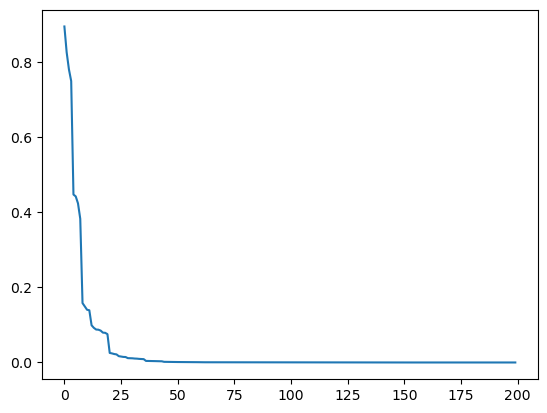

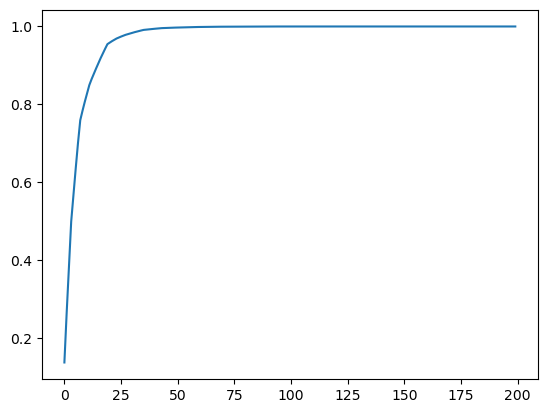

[0.1373584  0.26416519 0.38400164 0.49904521 0.56770535 0.63560307
 0.70065376 0.75939651 0.7836739  0.80661104 0.82816418 0.84950918
 0.86470825 0.87886954 0.8923413  0.90574299 0.91877511 0.9309797
 0.94310364 0.95468462 0.95858949 0.96229663 0.96574686 0.96904938
 0.97163295 0.97404732 0.97632062 0.9785552  0.98032683 0.98207268
 0.98378174 0.98539131 0.98695733 0.98842582 0.9898596  0.99122247
 0.99186221 0.99249164 0.99309415 0.99365791 0.99421516 0.99475676
 0.99529543 0.99577873 0.99604339 0.99628916 0.99651708 0.99673656
 0.99693302 0.99712349 0.99730631 0.99748689 0.99766078 0.99782942
 0.99798994 0.99814163 0.99828413 0.99841953 0.99854884 0.99866865
 0.99876751 0.99886024 0.99894574 0.9990298  0.99911071 0.99919056
 0.99926444 0.99933347 0.99936927 0.99940311 0.99943661 0.99946815
 0.99949798 0.99952763 0.9995571  0.99958546 0.99961332 0.99963994
 0.99966604 0.99969174 0.99971639 0.99974011 0.99976259 0.99978451
 0.99980563 0.99982631 0.99984647 0.99986501 0.99987952 0.99989

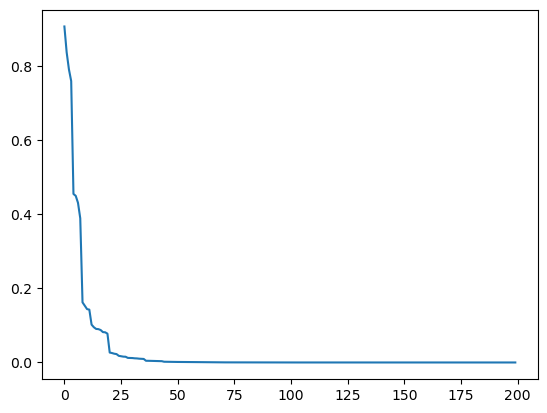

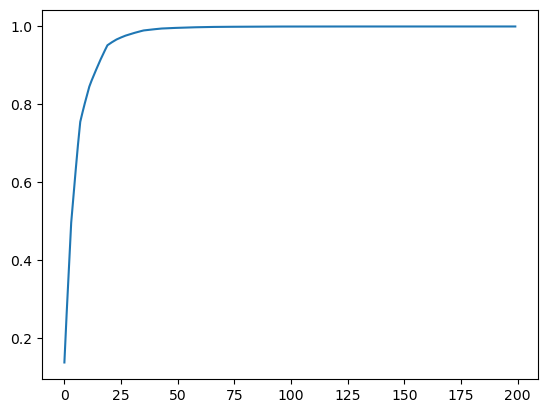

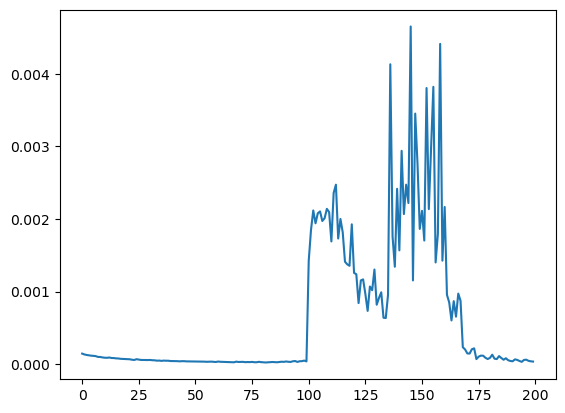

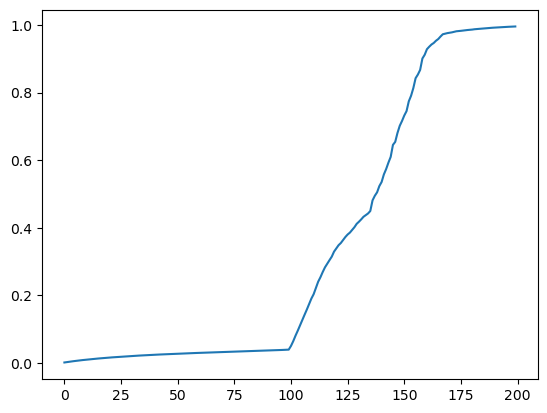

[0.00111503 0.00213992 0.00311258 0.0040481  0.00494415 0.00582388
 0.00667196 0.00743762 0.00819758 0.00890866 0.00959067 0.0102645
 0.01096927 0.01161974 0.01226527 0.01287739 0.01347856 0.01404433
 0.01460091 0.01513747 0.01567237 0.01619162 0.01666127 0.01710652
 0.01763135 0.01811479 0.01856104 0.01900273 0.01944802 0.01988449
 0.02032935 0.02074572 0.0211536  0.02152503 0.0219067  0.02225519
 0.02263339 0.02299847 0.02336349 0.02369654 0.02402737 0.02434653
 0.02466567 0.02496723 0.02528394 0.02560138 0.02589846 0.02619197
 0.02649332 0.02677349 0.02704595 0.02731999 0.02759497 0.0278566
 0.02812354 0.02837551 0.0286414  0.02891093 0.02916521 0.02939512
 0.02967385 0.02992727 0.03017142 0.03040575 0.03063377 0.03085363
 0.03107155 0.03127137 0.03153932 0.03177178 0.03201171 0.03225716
 0.03246752 0.03269583 0.03291212 0.03315242 0.03335717 0.03356021
 0.03381048 0.03402547 0.03422628 0.03440614 0.03460121 0.03480879
 0.0350387  0.03525413 0.03545437 0.03568806 0.03594727 0.036192

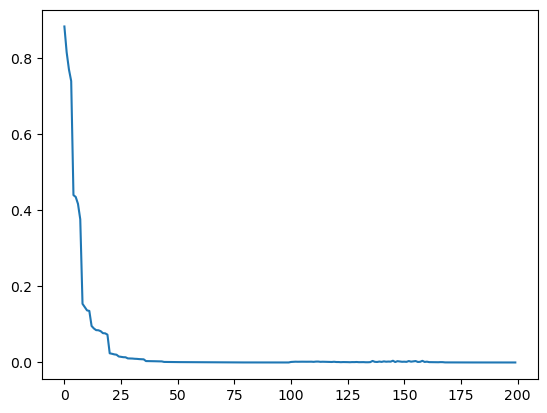

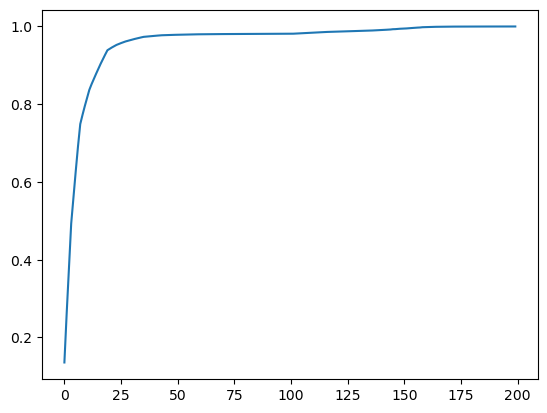

[0.13561814 0.2608216  0.37913976 0.49272464 0.56028436 0.62709733
 0.6911058  0.74890788 0.7725872  0.79496205 0.81598152 0.83679842
 0.85154354 0.86528479 0.87834815 0.89135361 0.90399768 0.91583879
 0.9276037  0.93884058 0.94254946 0.94606786 0.94934563 0.95248371
 0.95490912 0.95717734 0.95931499 0.96141574 0.9630682  0.96469692
 0.96628949 0.96778939 0.96924828 0.97061809 0.971954   0.97322474
 0.97380007 0.9743668  0.97490792 0.97541558 0.97591678 0.97640421
 0.97688922 0.97732351 0.97755118 0.97776192 0.97795668 0.97814463
 0.97831093 0.97847248 0.97862743 0.97878046 0.97892717 0.97906975
 0.97920511 0.97933299 0.97945252 0.97956608 0.97967377 0.97977383
 0.9798537  0.97992803 0.97999699 0.98006491 0.98013029 0.98019472
 0.98025421 0.98031012 0.9803368  0.98036186 0.98038732 0.98041101
 0.98043317 0.98045569 0.98047818 0.98049984 0.98052068 0.9805405
 0.98056055 0.98058028 0.98059858 0.98061616 0.98063293 0.98065015
 0.98066697 0.98068294 0.9806986  0.98071368 0.98072572 0.98073

In [6]:
def stand(x):
    return (x - np.mean(x, axis = 0)) / np.std(x, axis = 0)

large_n = 200 # used as the upper limit of number of PCs to use, set such that it's larger than what's required

# these lines are currently just for testing this cell, comment when running full code
# x_train = stand(x_train)
# y_train = stand(y_train)

### separate PCAs
x_pca = PCA(n_components = large_n)
x_pca.fit(x_train)

plt.plot(x_pca.explained_variance_)
plt.show()

plt.plot(np.cumsum(x_pca.explained_variance_ratio_))
plt.show()

print(np.cumsum(x_pca.explained_variance_ratio_))

n = np.where(np.cumsum(x_pca.explained_variance_ratio_) > 0.95)[0][0]

y_pca = PCA(n_components = large_n)
y_pca.fit(y_train)

plt.plot(y_pca.explained_variance_)
plt.show()

plt.plot(np.cumsum(y_pca.explained_variance_ratio_))
plt.show()

print(np.cumsum(y_pca.explained_variance_ratio_))

m = np.where(np.cumsum(y_pca.explained_variance_ratio_) > 0.99)[0][0]

print(f'n, m with individually-trained PCAs: {n, m}')

### combined PCA
combined_pca_full = PCA(n_components = 999)
combined_pca = PCA(n_components = large_n)
combined_train = np.concatenate((x_train, y_train), axis = 1)
combined_train_pca_full = combined_pca_full.fit_transform(combined_train)
combined_train_pca = combined_pca.fit_transform(combined_train)
print('does combined pca')

x_pca = PCA(n_components = large_n)
x_pca_full = PCA(n_components = 999)
y_pca = PCA(n_components = large_n)
y_pca_full = PCA(n_components = 999)

x_pca.components_ = combined_pca.components_[:, :4096]
x_pca_full.components_ = combined_pca_full.components_[:, :4096]
x_pca.mean_ = combined_pca.mean_[:4096]
x_pca_full.mean_ = combined_pca_full.mean_[:4096]

y_pca.components_ = combined_pca.components_[:, 4096:]
y_pca_full.components_ = combined_pca_full.components_[:, 4096:]
y_pca.mean_ = combined_pca.mean_[4096:]
y_pca_full.mean_ = combined_pca_full.mean_[4096:]

def compute_eigenvalues(components, original_data):
    # Reconstruct the covariance matrix from the components
    # `components` are the PCA components for either x_pca or y_pca
    # `original_data` should be x_train or y_train as applicable
    transformed_data = original_data @ components.T
    covariance_matrix = np.cov(transformed_data, rowvar=False)
    eigenvalues = np.diag(covariance_matrix)
    total_variance = np.sum(eigenvalues)

    return eigenvalues

def get_total_var(components, original_data):
    transformed_data = original_data @ components.T
    covariance_matrix = np.cov(transformed_data, rowvar=False)
    eigenvalues = np.diag(covariance_matrix)
    total_variance = np.sum(eigenvalues)

    return total_variance

x_eigenvalues = compute_eigenvalues(x_pca.components_, x_train - x_pca.mean_)
y_eigenvalues = compute_eigenvalues(y_pca.components_, y_train - y_pca.mean_)

x_pca.explained_variance_ratio_ = x_eigenvalues/get_total_var(x_pca_full.components_, x_train - x_pca_full.mean_)
y_pca.explained_variance_ratio_ = y_eigenvalues/get_total_var(y_pca_full.components_, y_train - y_pca_full.mean_)

x_pca.explained_variance_ = x_eigenvalues
y_pca.explained_variance_ = y_eigenvalues

plt.plot(combined_pca.explained_variance_)
plt.show()

plt.plot(np.cumsum(combined_pca.explained_variance_ratio_))
plt.show()

plt.plot(x_pca.explained_variance_)
plt.show()

plt.plot(np.cumsum(x_pca.explained_variance_ratio_))
plt.show()

print(np.cumsum(x_pca.explained_variance_ratio_))

plt.plot(y_pca.explained_variance_)
plt.show()

plt.plot(np.cumsum(y_pca.explained_variance_ratio_))
plt.show()

print(np.cumsum(y_pca.explained_variance_ratio_))

n = np.where(np.cumsum(x_pca.explained_variance_ratio_) > 0.95)[0][0]
m = np.where(np.cumsum(y_pca.explained_variance_ratio_) > 0.99)[0][0]

print(f'n, m with combined PCA: {n, m}')

# Train

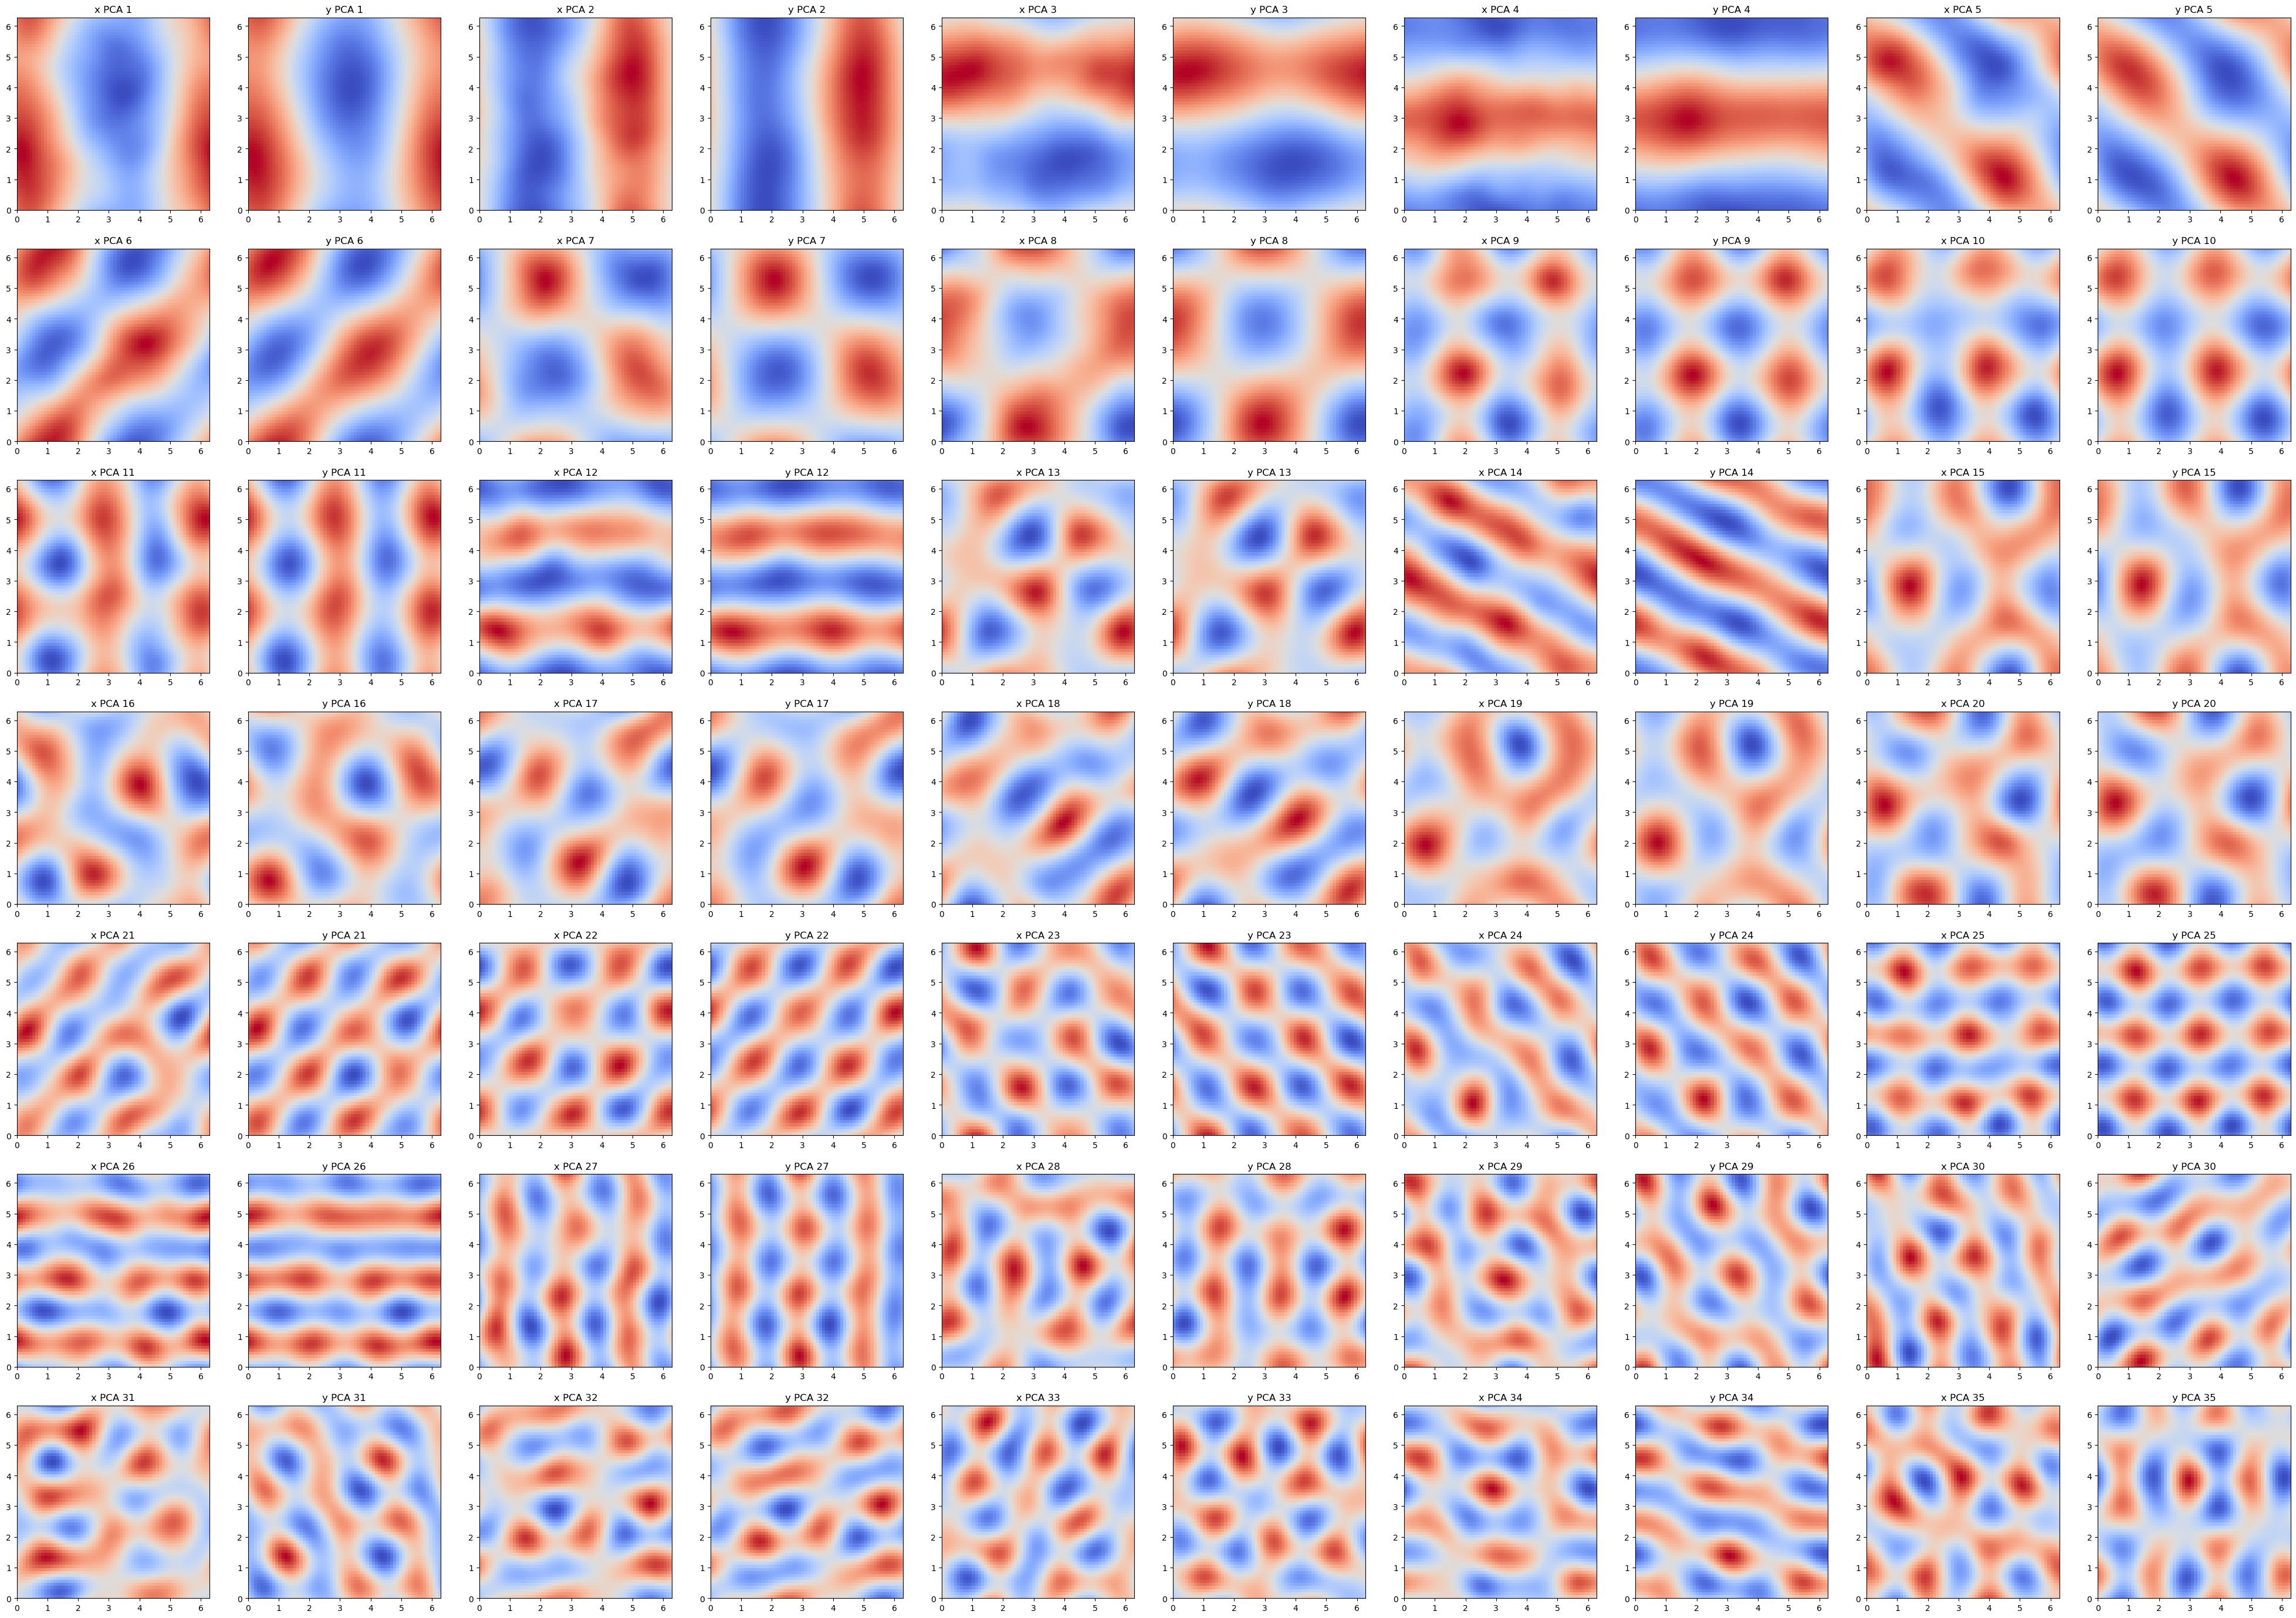

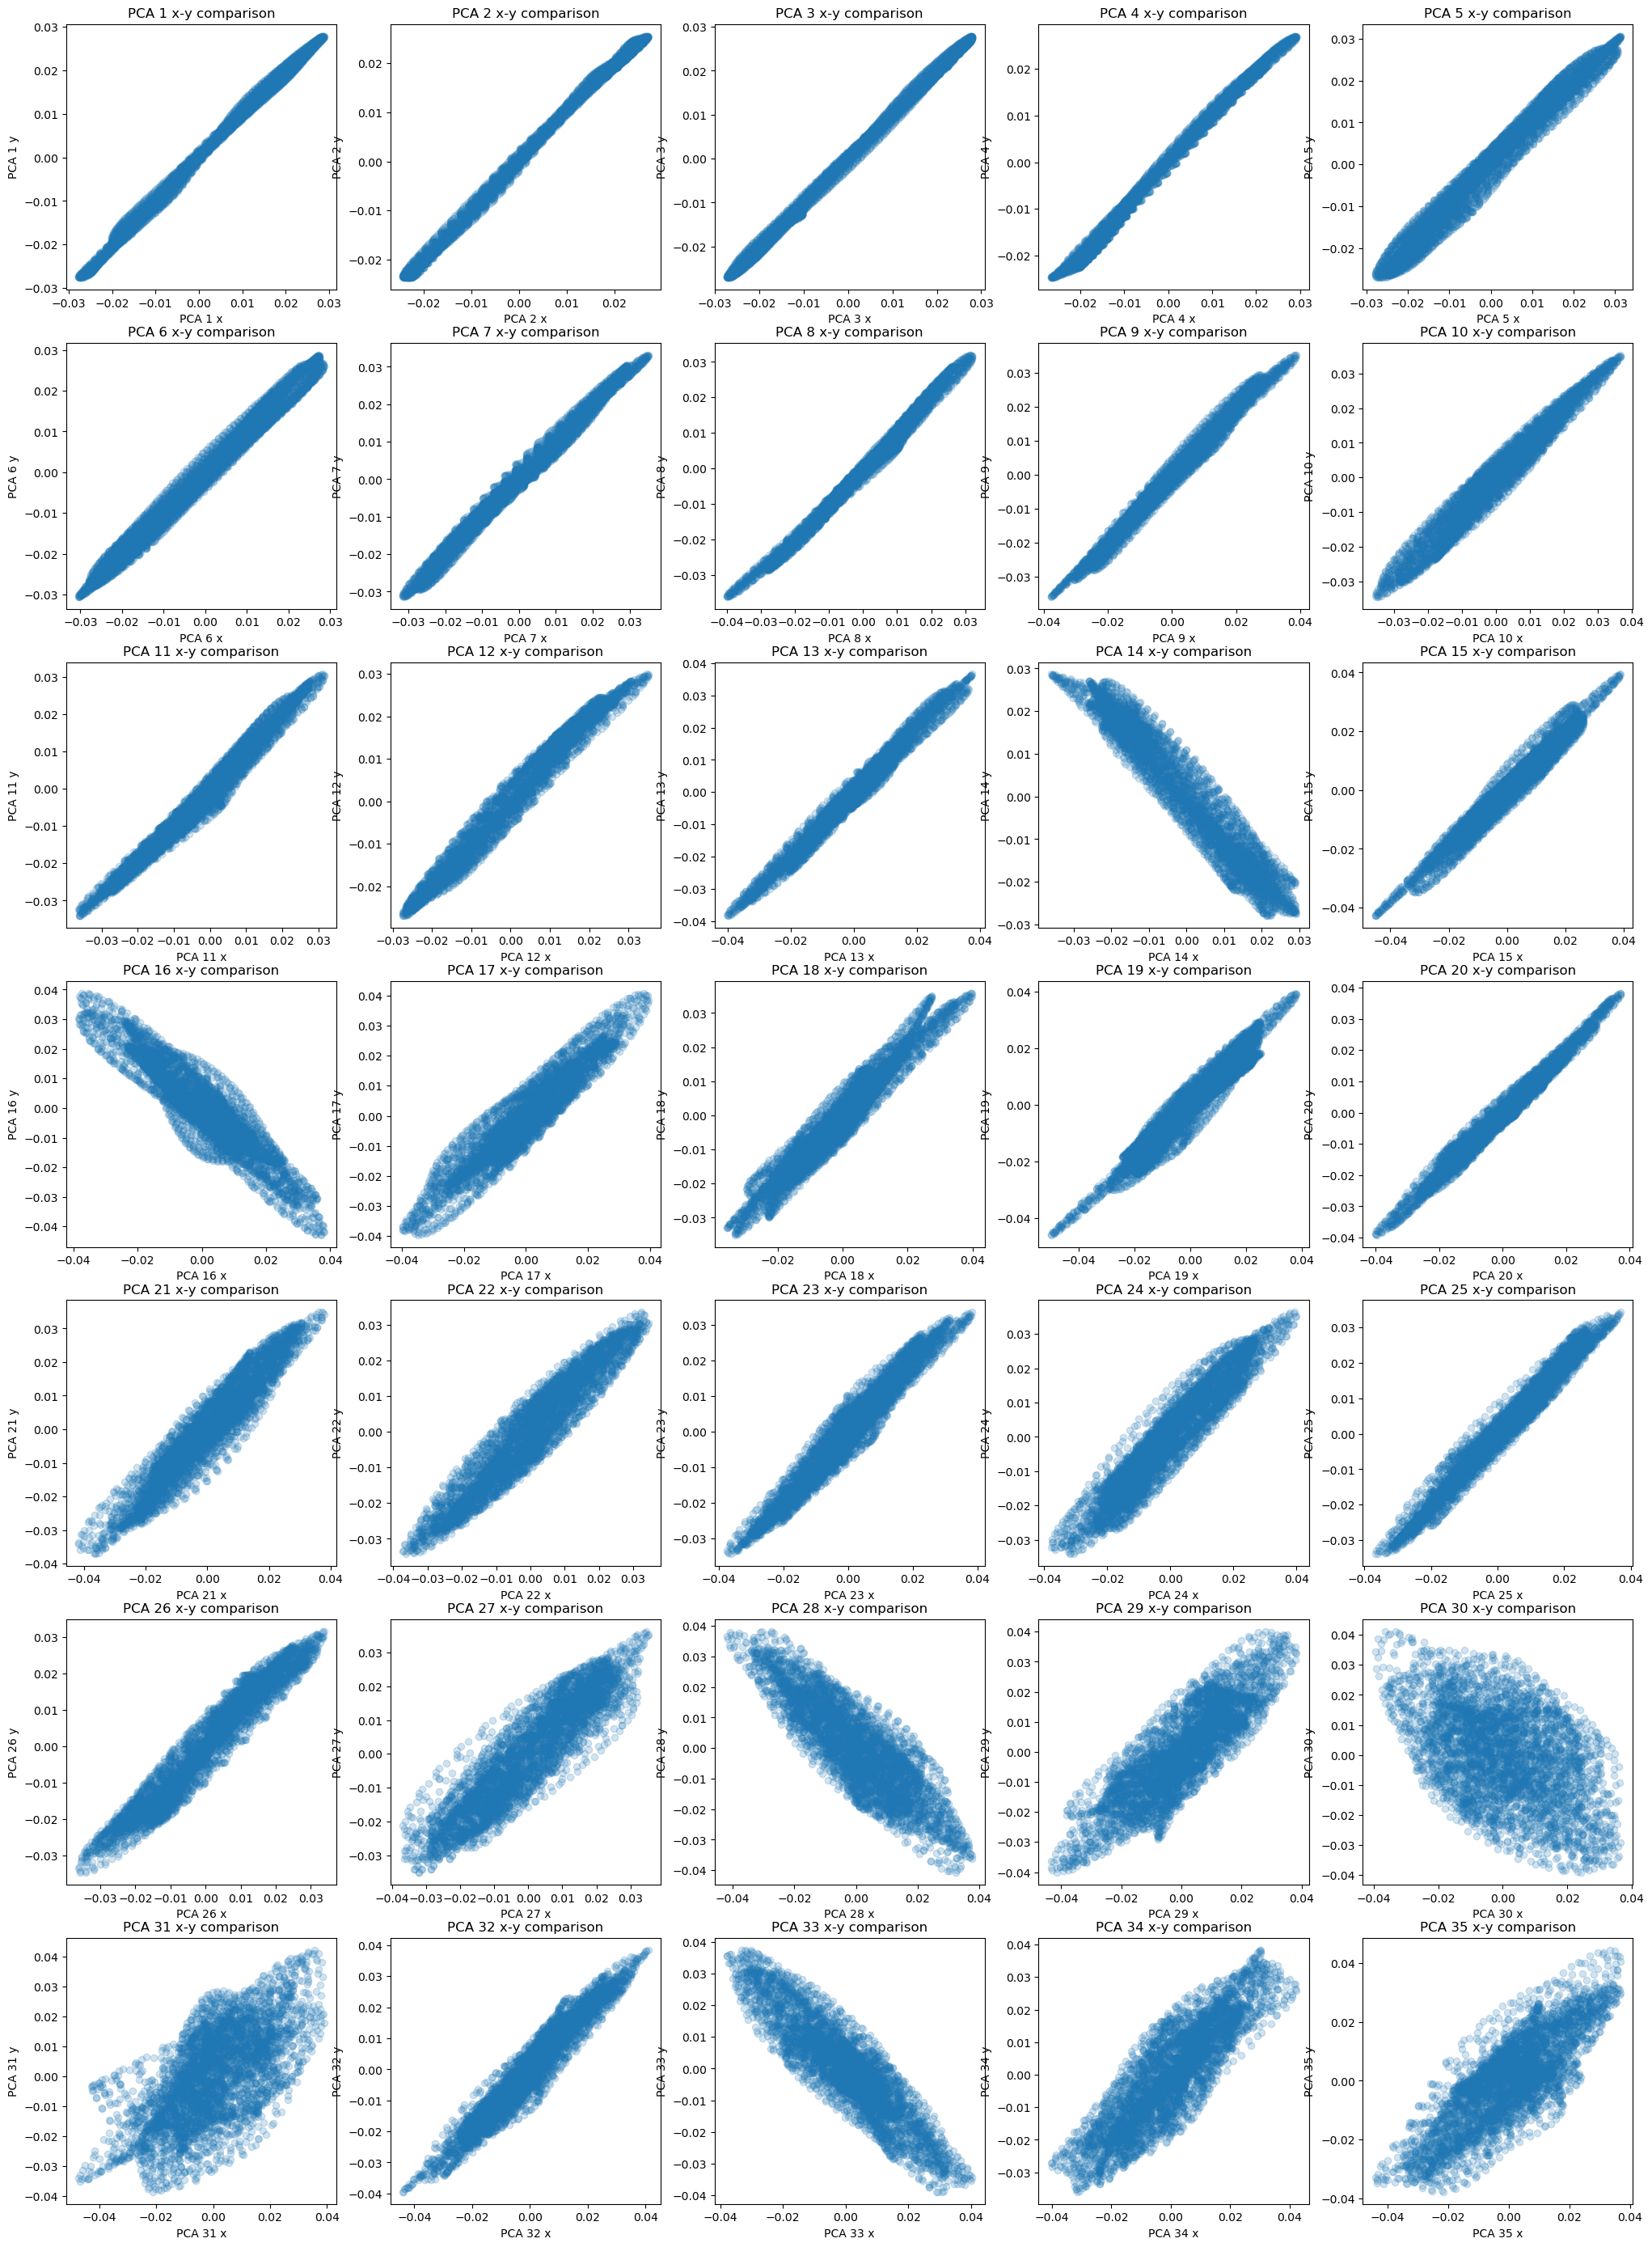

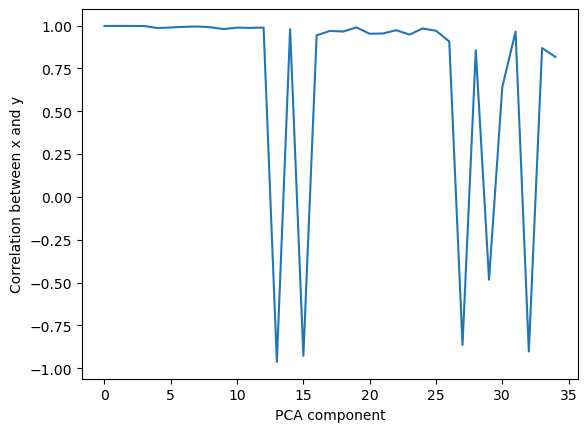

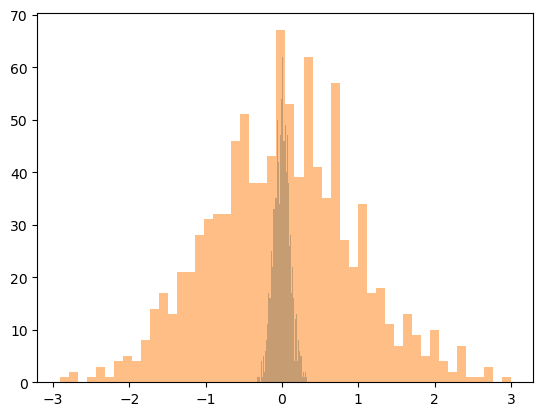

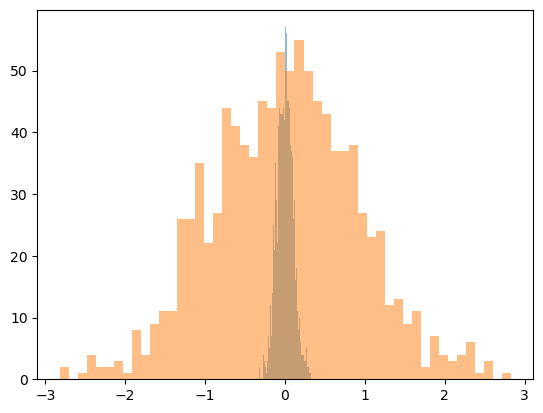

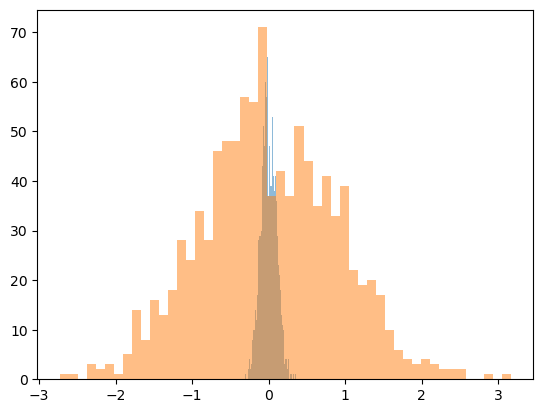

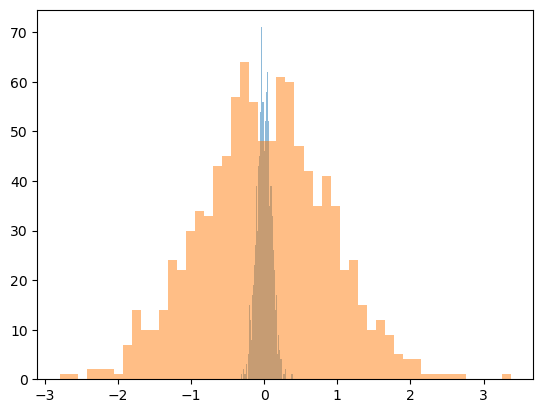

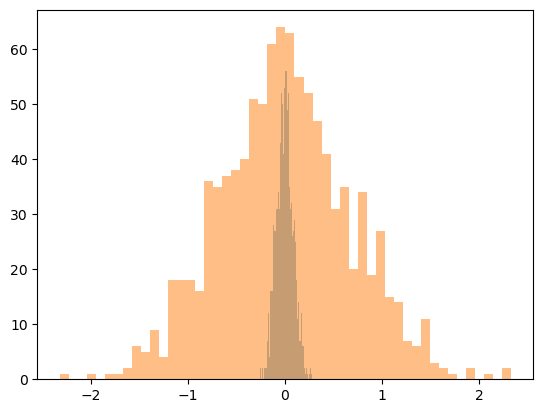

standardising


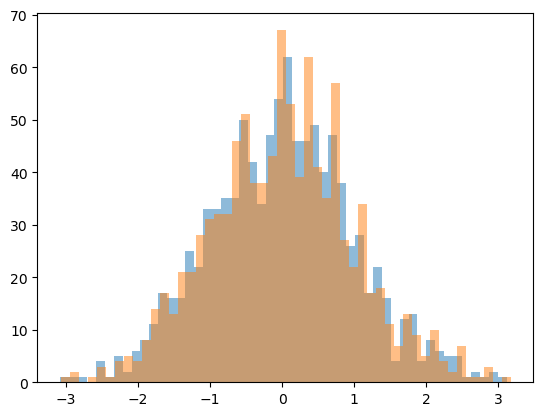

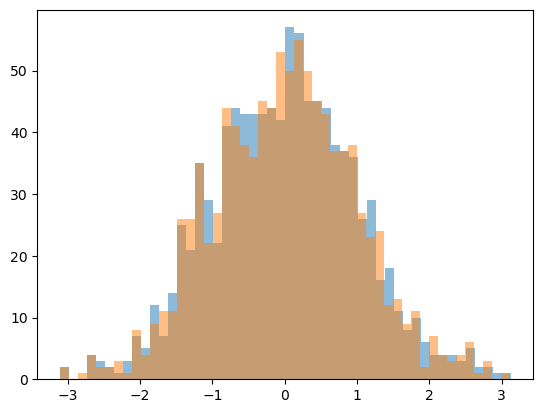

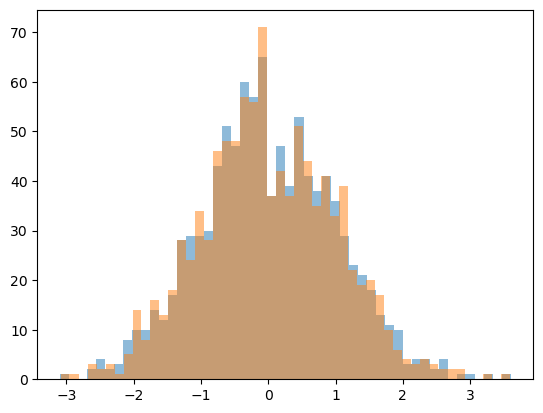

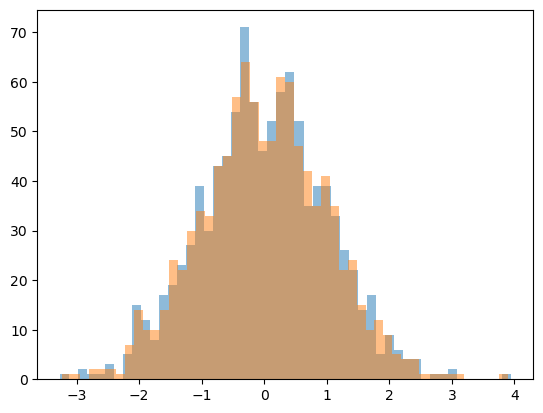

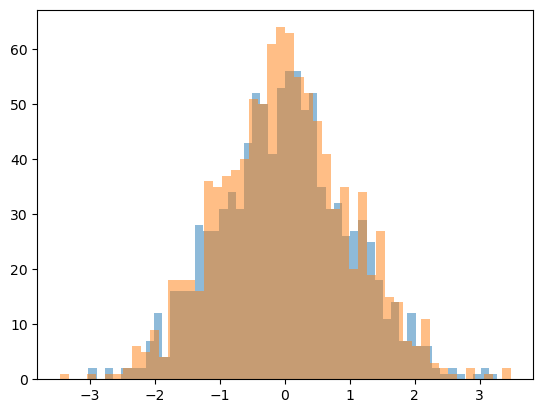

In [ ]:
x_train_pca = PCA(n_components=45).fit(x_train)
y_train_pca = PCA(n_components=35).fit(y_train)

fig, ax = plt.subplots(7, 10, figsize=(50, 35))
ax = ax.flatten()

for i in range(0, 70, 2):
    ax[i].imshow(x_train_pca.components_[int(i/2), :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], cmap='coolwarm')
    ax[i].set_title(f"x PCA {int(i/2)+1}")
    ax[i+1].imshow(y_train_pca.components_[int(i/2), :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], cmap='coolwarm')
    ax[i+1].set_title(f"y PCA {int(i/2)+1}")
plt.show()

corr_list = []
fig, ax = plt.subplots(7, 5, figsize=(25, 35))
ax = ax.flatten()
for i in range(0, 35):
    ax[i].plot(x_train_pca.components_[i, :], y_train_pca.components_[i, :], marker='o', linestyle='', alpha = 0.2)
    ax[i].set_xlabel(f"PCA {i+1} x")
    ax[i].set_ylabel(f"PCA {i+1} y")
    ax[i].set_title(f"PCA {i+1} x-y comparison")
    corr_list.append(np.corrcoef(x_train_pca.components_[i, :], y_train_pca.components_[i, :])[0, 1])
plt.show()

plt.figure()
plt.plot(corr_list)
plt.xlabel('PCA component')
plt.ylabel('Correlation between x and y')
plt.show()

x_train_pca = x_train_pca.transform(x_train)
y_train_pca = y_train_pca.transform(y_train)

for i in range(5):
    plt.figure()
    plt.hist(x_train_pca[:, i], bins=50, label = f'x_train_pca {i+1}', alpha=0.5)
    plt.hist(y_train_pca[:, i], bins=50, label = f'y_train_pca {i+1}', alpha=0.5)
    plt.show()

print('standardising')

for i in range(5):
    x_train_pca_stand_i = (x_train_pca[:, i] - x_train_pca[:, i].mean(axis = 0))/x_train_pca[:, i].std(axis = 0)
    y_train_pca_stand_i = (y_train_pca[:, i] - y_train_pca[:, i].mean(axis = 0))/y_train_pca[:, i].std(axis = 0)
    plt.figure()
    plt.hist(x_train_pca_stand_i, bins=50, label = f'x_train_pca_stand {i+1}', alpha=0.5)
    plt.hist(y_train_pca_stand_i, bins=50, label = f'y_train_pca_stand {i+1}', alpha=0.5)
    plt.show()


(1000, 8192)


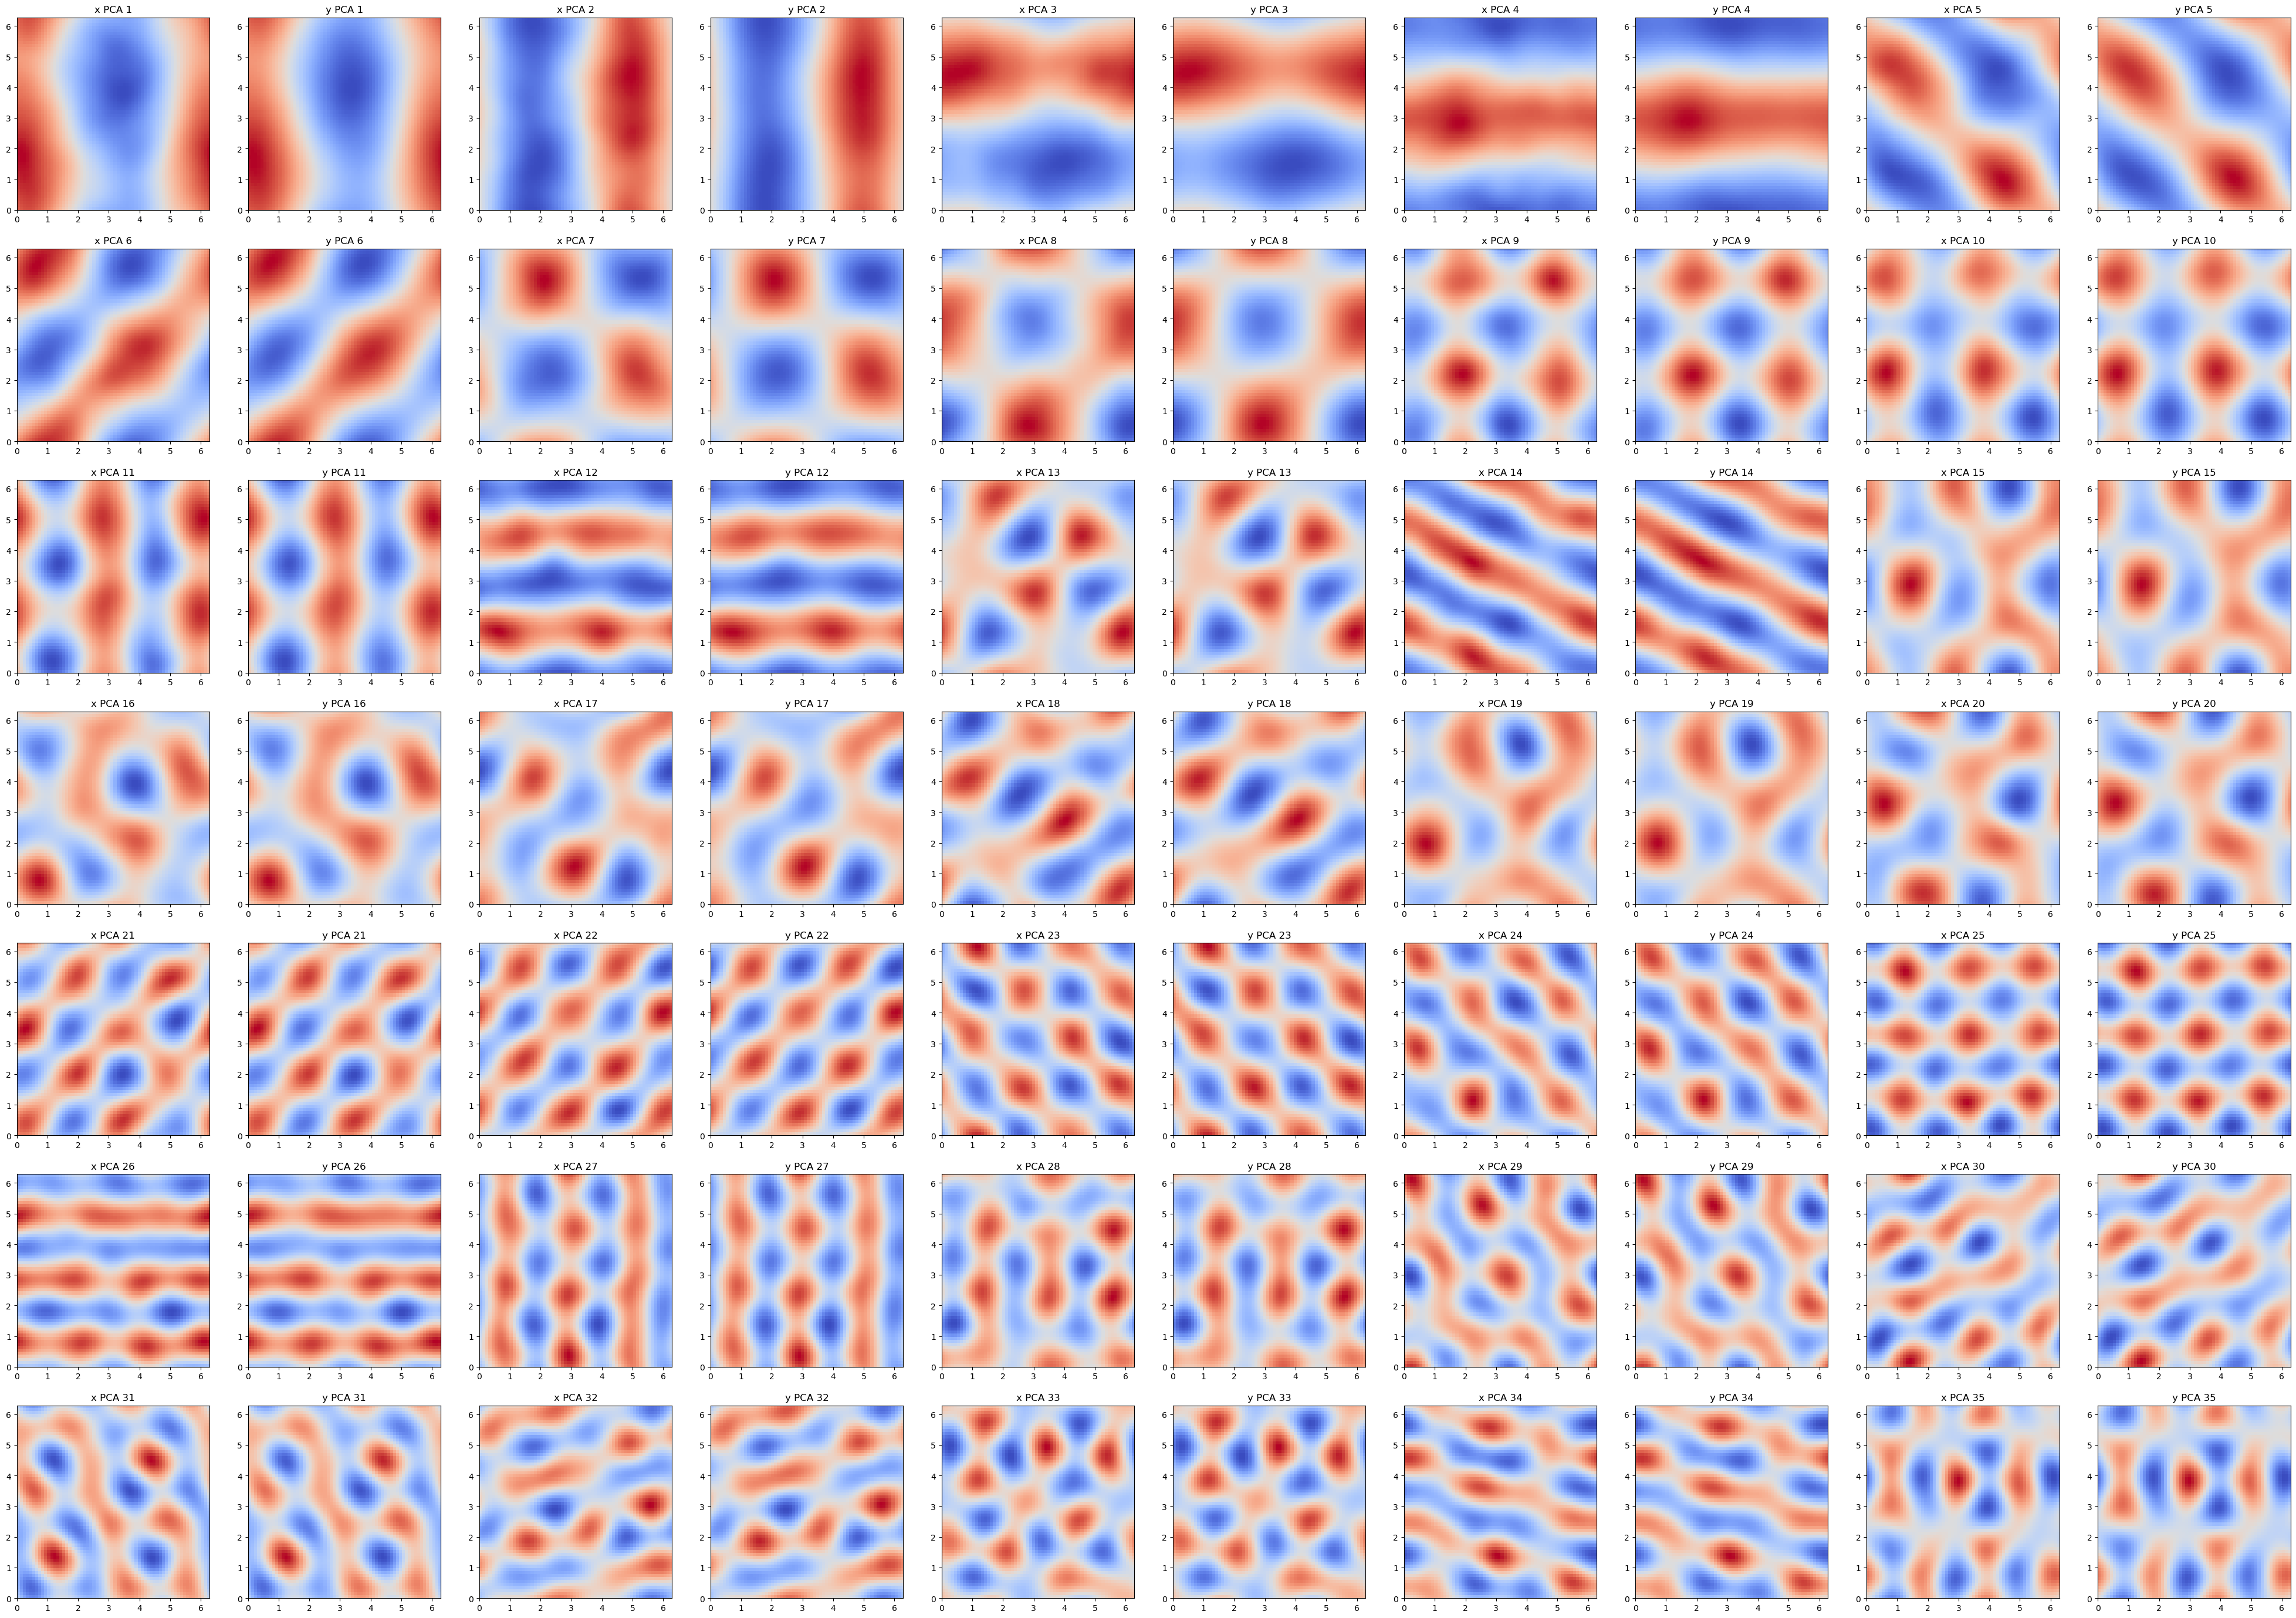

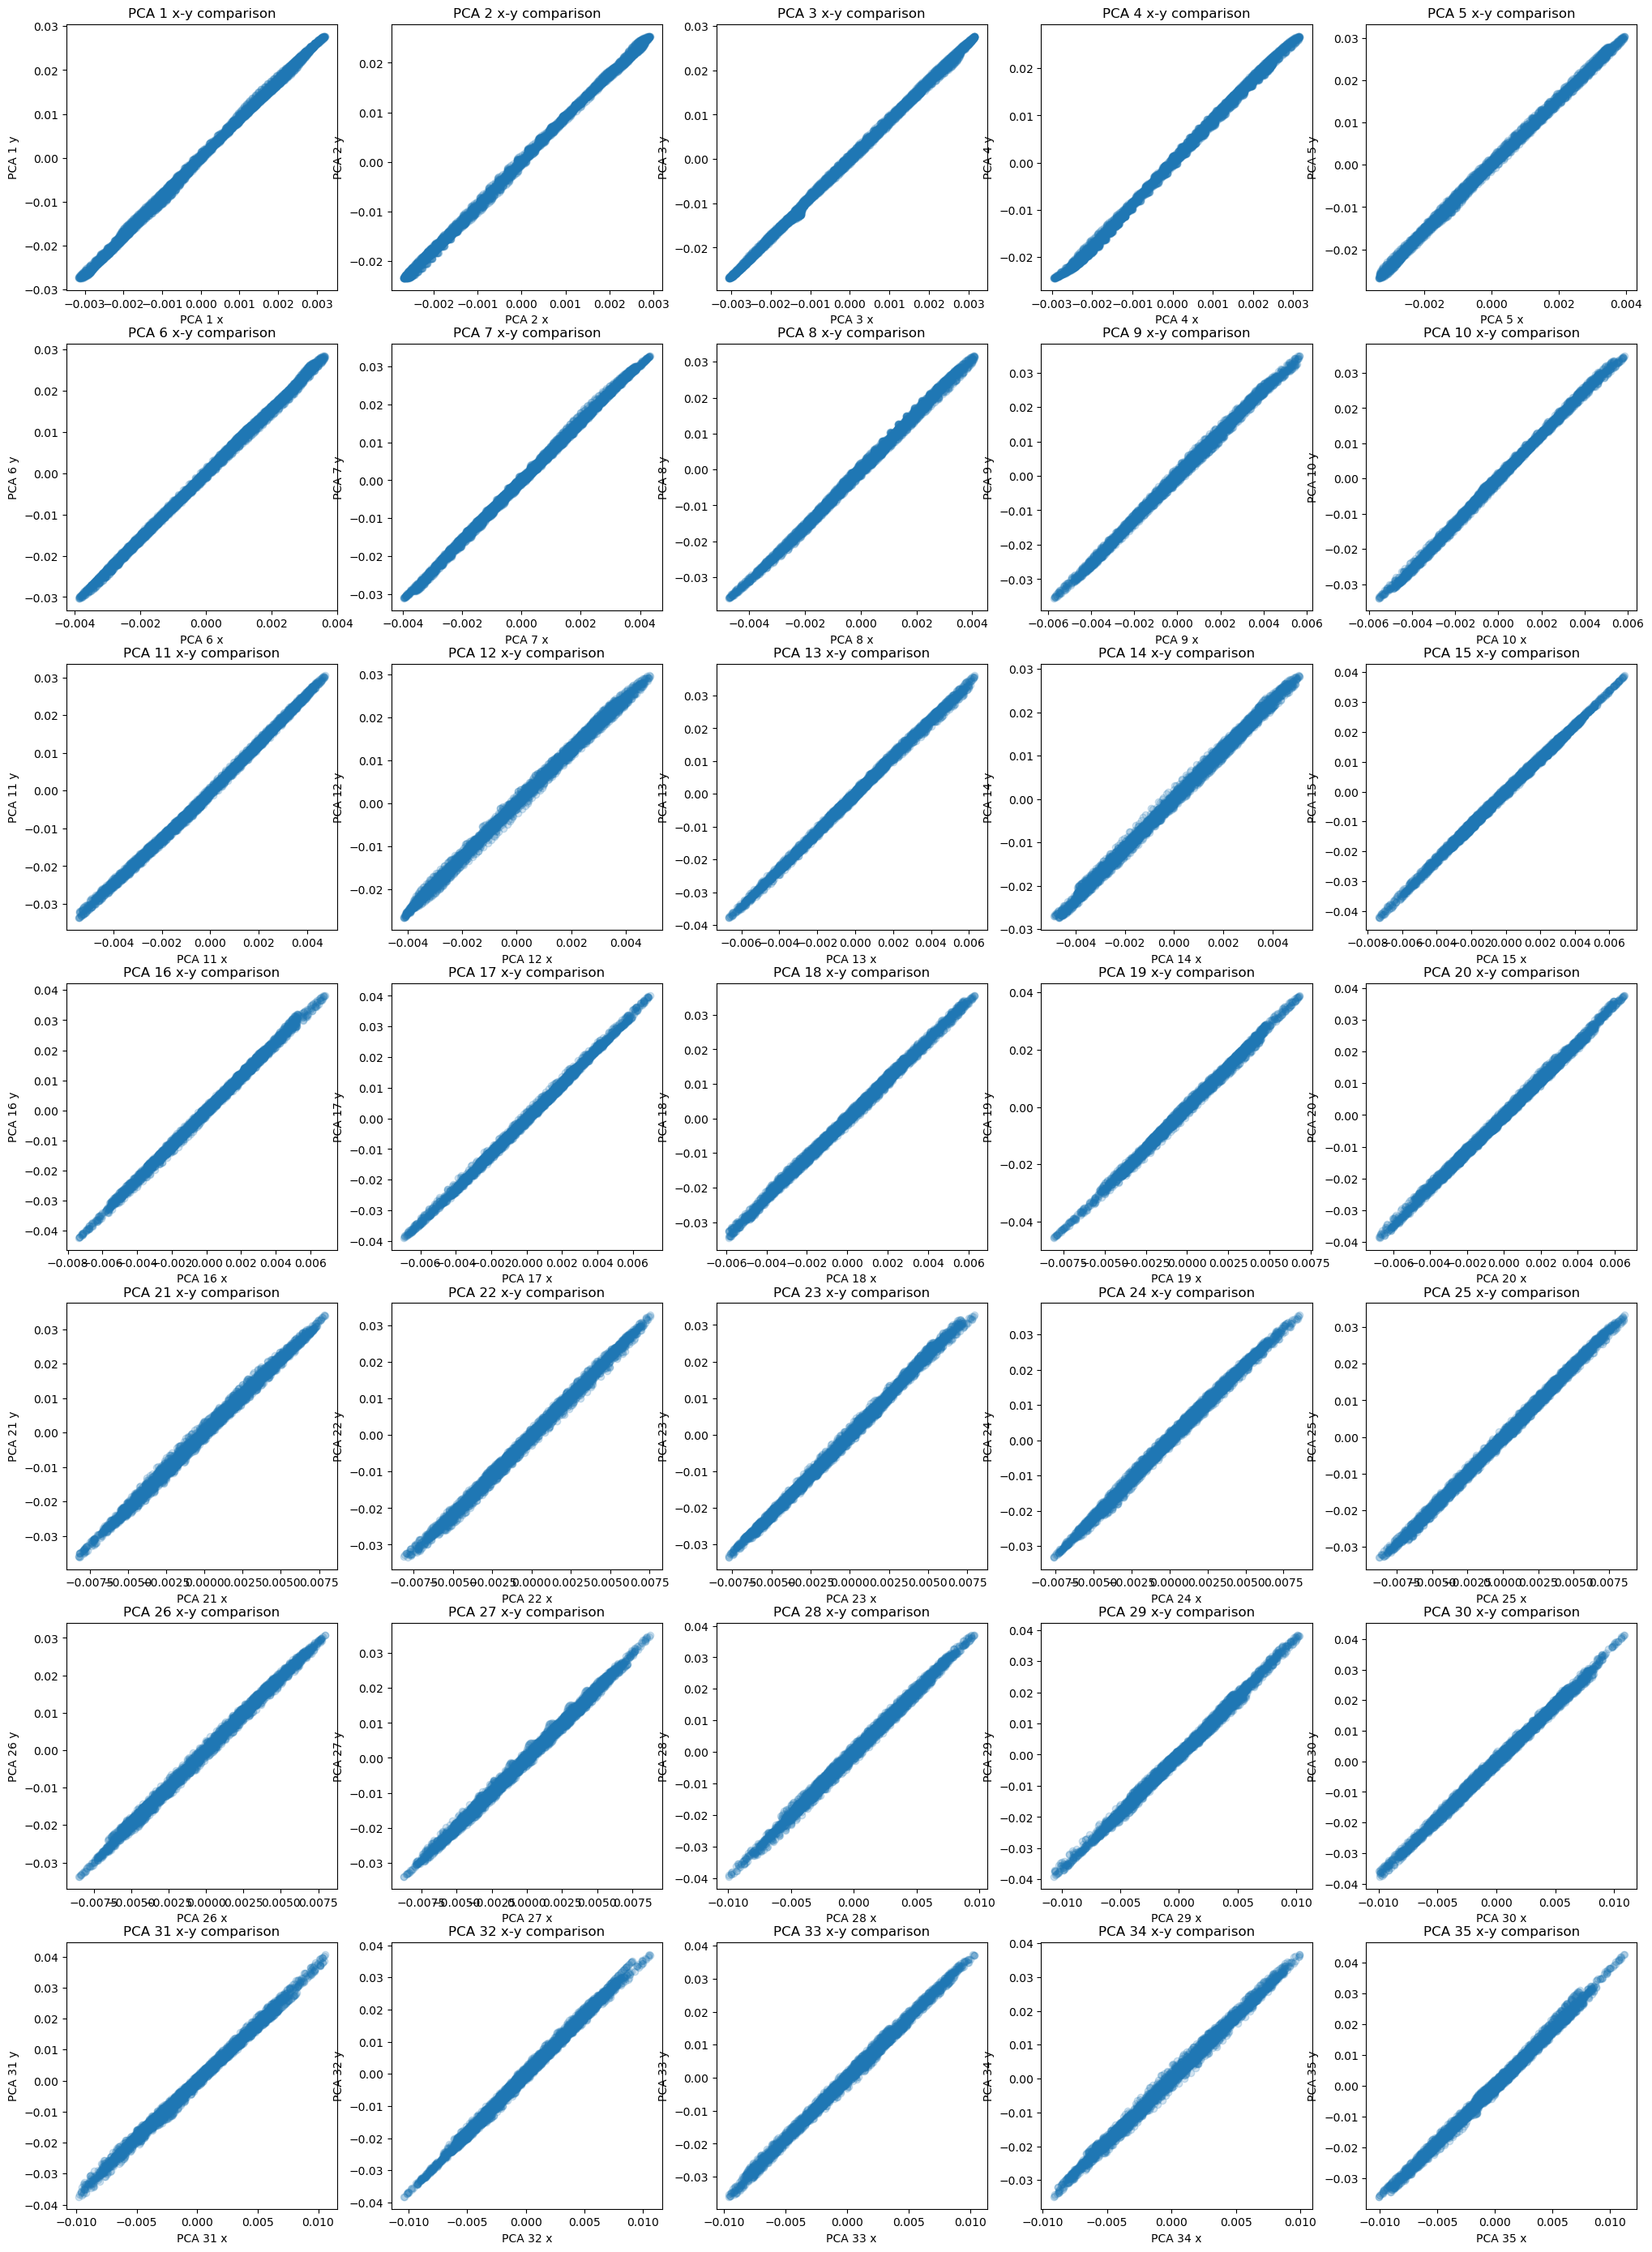

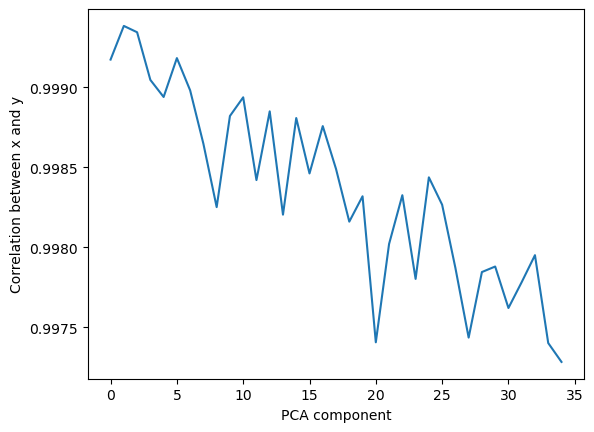

(1000, 45)


In [7]:
# stack x_train and y_train

combined_train = np.concatenate((x_train, y_train), axis = 1)
print(combined_train.shape)

combined_train_pca = PCA(n_components=45).fit(combined_train)

fig, ax = plt.subplots(7, 10, figsize=(50, 35))
ax = ax.flatten()

for i in range(0, 70, 2):
    ax[i].imshow(combined_train_pca.components_[int(i/2), :4096].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], cmap='coolwarm')
    ax[i].set_title(f"x PCA {int(i/2)+1}")
    ax[i+1].imshow(combined_train_pca.components_[int(i/2), 4096:].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], cmap='coolwarm')
    ax[i+1].set_title(f"y PCA {int(i/2)+1}")
plt.show()

corr_list = []
fig, ax = plt.subplots(7, 5, figsize=(25, 35))
ax = ax.flatten()
for i in range(0, 35):
    ax[i].plot(combined_train_pca.components_[i, :4096], combined_train_pca.components_[i, 4096:], marker='o', linestyle='', alpha = 0.2)
    ax[i].set_xlabel(f"PCA {i+1} x")
    ax[i].set_ylabel(f"PCA {i+1} y")
    ax[i].set_title(f"PCA {i+1} x-y comparison")
    corr_list.append(np.corrcoef(combined_train_pca.components_[i, :4096], combined_train_pca.components_[i, 4096:])[0, 1])
plt.show()

plt.figure()
plt.plot(corr_list)
plt.xlabel('PCA component')
plt.ylabel('Correlation between x and y')
plt.show()

combined_train_pca = combined_train_pca.transform(combined_train)
print(combined_train_pca.shape)

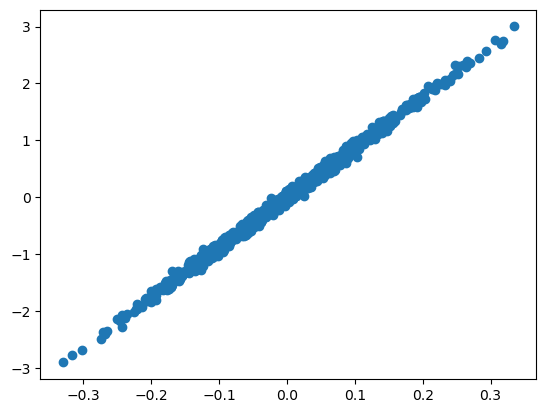

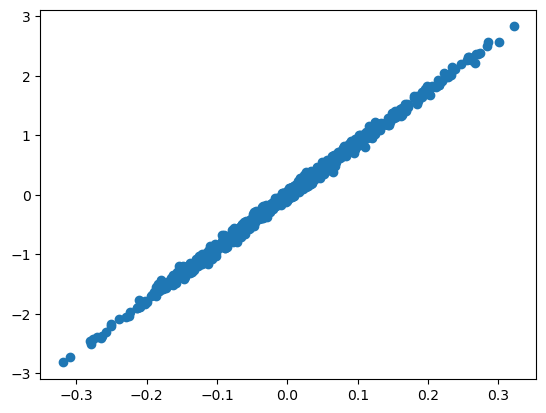

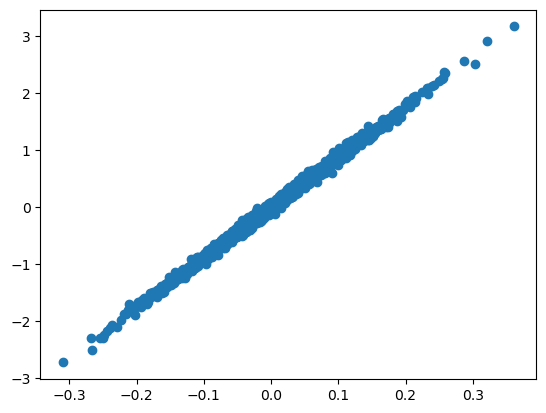

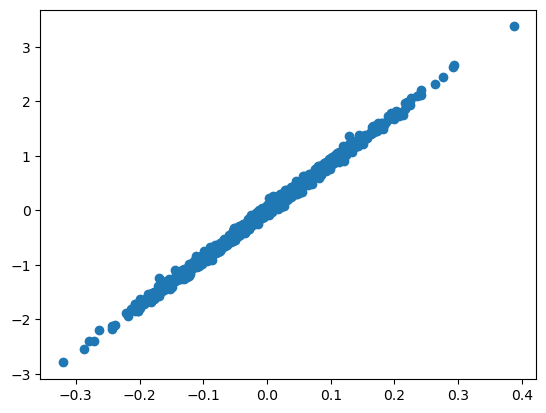

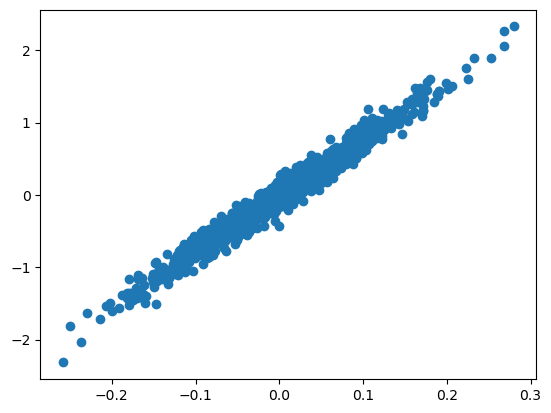

In [ ]:
for i in range(5):
    plt.figure()
    plt.plot(x_train_pca[:, i], y_train_pca[:, i], 'o')
    plt.show()

In [ ]:
## Train

n, m = 45, 45 # n, m = 45, 35 for variance explained 0.95, 0.99

model = full_model(n = n, m = m, ARD = False, multiinput = True, standardise = True, combine_pca = True)
train_samples = model.fit(x_train, y_train)

does combined pca
does x pca
does y pca


  0%|          | 0/45 [00:00<?, ?it/s]

[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
  2%|▏         | 1/45 [01:04<47:36, 64.92s/it]

         Current function value: -2283.112664
         Iterations: 49
         Function evaluations: 119
         Gradient evaluations: 107
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([61.47173834], dtype=float64), variance=Array([9.99999999], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.0017891], dtype=float64))
[2.]
[1.]
[1.]
float64


  4%|▍         | 2/45 [01:33<31:06, 43.41s/it]

Optimization terminated successfully.
         Current function value: -2270.207068
         Iterations: 33
         Function evaluations: 39
         Gradient evaluations: 39
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([60.71493562], dtype=float64), variance=Array([9.9999998], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00110292], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
  7%|▋         | 3/45 [02:26<33:29, 47.84s/it]

         Current function value: -2198.015136
         Iterations: 46
         Function evaluations: 95
         Gradient evaluations: 83
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([59.32680601], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00337009], dtype=float64))
[2.]
[1.]
[1.]
float64


  9%|▉         | 4/45 [03:06<30:36, 44.79s/it]

Optimization terminated successfully.
         Current function value: -2171.419293
         Iterations: 49
         Function evaluations: 56
         Gradient evaluations: 56
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([58.13671596], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00287396], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 11%|█         | 5/45 [04:00<31:59, 47.98s/it]

         Current function value: -2118.265388
         Iterations: 50
         Function evaluations: 87
         Gradient evaluations: 76
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([56.44520072], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00306641], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 13%|█▎        | 6/45 [04:59<33:36, 51.71s/it]

         Current function value: -2098.599766
         Iterations: 51
         Function evaluations: 100
         Gradient evaluations: 89
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([56.3390277], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00406371], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 16%|█▌        | 7/45 [05:58<34:14, 54.07s/it]

         Current function value: -2103.199585
         Iterations: 52
         Function evaluations: 99
         Gradient evaluations: 87
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([55.55965257], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00257718], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 18%|█▊        | 8/45 [06:42<31:21, 50.86s/it]

         Current function value: -2037.065291
         Iterations: 25
         Function evaluations: 83
         Gradient evaluations: 72
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([54.51282066], dtype=float64), variance=Array([9.99996772], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00427985], dtype=float64))
[2.]
[1.]
[1.]
float64


 20%|██        | 9/45 [07:32<30:26, 50.73s/it]

Optimization terminated successfully.
         Current function value: -1308.612056
         Iterations: 49
         Function evaluations: 75
         Gradient evaluations: 74
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([36.13578282], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00497648], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 22%|██▏       | 10/45 [09:02<36:35, 62.74s/it]

         Current function value: -1299.710922
         Iterations: 58
         Function evaluations: 173
         Gradient evaluations: 160
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([35.79755283], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00338179], dtype=float64))
[2.]
[1.]
[1.]
float64


 24%|██▍       | 11/45 [09:44<31:58, 56.44s/it]

Optimization terminated successfully.
         Current function value: -1292.483900
         Iterations: 43
         Function evaluations: 64
         Gradient evaluations: 64
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([36.18536724], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00806892], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 27%|██▋       | 12/45 [10:50<32:44, 59.54s/it]

         Current function value: -1231.726057
         Iterations: 53
         Function evaluations: 121
         Gradient evaluations: 108
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([35.14934885], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00902326], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 29%|██▉       | 13/45 [12:01<33:35, 63.00s/it]

         Current function value: -1085.362473
         Iterations: 34
         Function evaluations: 150
         Gradient evaluations: 137
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([31.85367397], dtype=float64), variance=Array([9.99991525], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00100423], dtype=float64))
[2.]
[1.]
[1.]
float64


 31%|███       | 14/45 [12:51<30:27, 58.96s/it]

Optimization terminated successfully.
         Current function value: -1042.256851
         Iterations: 51
         Function evaluations: 77
         Gradient evaluations: 77
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([31.67024843], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00925772], dtype=float64))
[2.]
[1.]
[1.]
float64


 33%|███▎      | 15/45 [13:16<24:18, 48.61s/it]

Optimization terminated successfully.
         Current function value: -1007.484172
         Iterations: 28
         Function evaluations: 34
         Gradient evaluations: 34
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([30.71181434], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00262128], dtype=float64))
[2.]
[1.]
[1.]
float64


 36%|███▌      | 16/45 [13:55<22:07, 45.77s/it]

Optimization terminated successfully.
         Current function value: -1018.387379
         Iterations: 46
         Function evaluations: 54
         Gradient evaluations: 54
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([31.38070144], dtype=float64), variance=Array([9.99999998], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.01066909], dtype=float64))
[2.]
[1.]
[1.]
float64


 38%|███▊      | 17/45 [14:28<19:34, 41.95s/it]

Optimization terminated successfully.
         Current function value: -1026.675592
         Iterations: 38
         Function evaluations: 44
         Gradient evaluations: 44
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([30.97653704], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00100024], dtype=float64))
[2.]
[1.]
[1.]
float64


 40%|████      | 18/45 [15:01<17:42, 39.35s/it]

Optimization terminated successfully.
         Current function value: -967.265996
         Iterations: 34
         Function evaluations: 40
         Gradient evaluations: 40
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([30.14457575], dtype=float64), variance=Array([9.99999998], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00100009], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 42%|████▏     | 19/45 [15:33<16:08, 37.24s/it]

         Current function value: -965.990407
         Iterations: 26
         Function evaluations: 55
         Gradient evaluations: 44
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([30.19372625], dtype=float64), variance=Array([9.99999931], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00635198], dtype=float64))
[2.]
[1.]
[1.]
float64


 44%|████▍     | 20/45 [16:27<17:30, 42.00s/it]

Optimization terminated successfully.
         Current function value: -941.463915
         Iterations: 55
         Function evaluations: 82
         Gradient evaluations: 82
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([30.00499935], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00945423], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 47%|████▋     | 21/45 [17:18<17:59, 44.99s/it]

         Current function value: -626.574703
         Iterations: 37
         Function evaluations: 97
         Gradient evaluations: 85
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([25.24758949], dtype=float64), variance=Array([9.99997824], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00100267], dtype=float64))
[2.]
[1.]
[1.]
float64


 49%|████▉     | 22/45 [18:16<18:38, 48.64s/it]

Optimization terminated successfully.
         Current function value: -616.880308
         Iterations: 56
         Function evaluations: 89
         Gradient evaluations: 89
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([25.47142421], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.01578646], dtype=float64))
[2.]
[1.]
[1.]
float64


 51%|█████     | 23/45 [19:02<17:35, 47.99s/it]

Optimization terminated successfully.
         Current function value: -569.861344
         Iterations: 45
         Function evaluations: 67
         Gradient evaluations: 67
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([24.92624751], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.01807864], dtype=float64))
[2.]
[1.]
[1.]
float64


 53%|█████▎    | 24/45 [20:06<18:30, 52.86s/it]

Optimization terminated successfully.
         Current function value: -542.280454
         Iterations: 65
         Function evaluations: 100
         Gradient evaluations: 100
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([24.5681045], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.01903336], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 56%|█████▌    | 25/45 [21:13<19:02, 57.14s/it]

         Current function value: -740.325792
         Iterations: 61
         Function evaluations: 110
         Gradient evaluations: 100
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([28.15954359], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.0278126], dtype=float64))
[2.]
[1.]
[1.]
float64


 58%|█████▊    | 26/45 [22:02<17:16, 54.53s/it]

Optimization terminated successfully.
         Current function value: -669.207981
         Iterations: 58
         Function evaluations: 65
         Gradient evaluations: 65
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([27.07073529], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.02911183], dtype=float64))
[2.]
[1.]
[1.]
float64


 60%|██████    | 27/45 [22:40<14:54, 49.69s/it]

Optimization terminated successfully.
         Current function value: -690.794455
         Iterations: 44
         Function evaluations: 53
         Gradient evaluations: 53
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([27.12415913], dtype=float64), variance=Array([9.99999902], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.02601727], dtype=float64))
[2.]
[1.]
[1.]
float64


 62%|██████▏   | 28/45 [23:24<13:32, 47.79s/it]

Optimization terminated successfully.
         Current function value: -615.187897
         Iterations: 51
         Function evaluations: 58
         Gradient evaluations: 58
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([26.33856951], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.0307716], dtype=float64))
[2.]
[1.]
[1.]
float64


 64%|██████▍   | 29/45 [24:21<13:28, 50.53s/it]

Optimization terminated successfully.
         Current function value: -564.134575
         Iterations: 65
         Function evaluations: 76
         Gradient evaluations: 76
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([25.19996918], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.02583924], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 67%|██████▋   | 30/45 [25:17<13:04, 52.30s/it]

         Current function value: -543.488710
         Iterations: 43
         Function evaluations: 98
         Gradient evaluations: 87
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([24.89468357], dtype=float64), variance=Array([9.99997915], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.02569407], dtype=float64))
[2.]
[1.]
[1.]
float64


 69%|██████▉   | 31/45 [25:55<11:12, 48.06s/it]

Optimization terminated successfully.
         Current function value: -568.884901
         Iterations: 44
         Function evaluations: 53
         Gradient evaluations: 53
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([25.65614558], dtype=float64), variance=Array([9.9999991], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.0319771], dtype=float64))
[2.]
[1.]
[1.]
float64


 71%|███████   | 32/45 [26:44<10:26, 48.17s/it]

Optimization terminated successfully.
         Current function value: -499.286595
         Iterations: 49
         Function evaluations: 67
         Gradient evaluations: 67
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([24.52048004], dtype=float64), variance=Array([9.99999933], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.03058148], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 73%|███████▎  | 33/45 [27:59<11:16, 56.39s/it]

         Current function value: -497.032136
         Iterations: 59
         Function evaluations: 124
         Gradient evaluations: 113
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([24.65682495], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.03323386], dtype=float64))
[2.]
[1.]
[1.]
float64


 76%|███████▌  | 34/45 [28:35<09:12, 50.27s/it]

Optimization terminated successfully.
         Current function value: -455.420209
         Iterations: 44
         Function evaluations: 49
         Gradient evaluations: 49
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([24.65202321], dtype=float64), variance=Array([9.99999946], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.04310245], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 78%|███████▊  | 35/45 [29:46<09:25, 56.52s/it]

         Current function value: -432.438884
         Iterations: 62
         Function evaluations: 110
         Gradient evaluations: 99
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([24.11073494], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.03965249], dtype=float64))
[2.]
[1.]
[1.]
float64


 80%|████████  | 36/45 [30:28<07:49, 52.13s/it]

Optimization terminated successfully.
         Current function value: -440.683498
         Iterations: 46
         Function evaluations: 55
         Gradient evaluations: 55
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([23.87681234], dtype=float64), variance=Array([9.99999962], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.0339114], dtype=float64))
[2.]
[1.]
[1.]
float64


 82%|████████▏ | 37/45 [31:12<06:37, 49.70s/it]

Optimization terminated successfully.
         Current function value: -271.403750
         Iterations: 48
         Function evaluations: 54
         Gradient evaluations: 54
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([22.80096761], dtype=float64), variance=Array([9.99999996], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.0596422], dtype=float64))
[2.]
[1.]
[1.]
float64


 84%|████████▍ | 38/45 [31:50<05:23, 46.18s/it]

Optimization terminated successfully.
         Current function value: -319.891172
         Iterations: 44
         Function evaluations: 50
         Gradient evaluations: 50
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([23.40137276], dtype=float64), variance=Array([9.99999985], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.0568148], dtype=float64))
[2.]
[1.]
[1.]
float64


 87%|████████▋ | 39/45 [32:25<04:15, 42.64s/it]

Optimization terminated successfully.
         Current function value: -242.827627
         Iterations: 40
         Function evaluations: 46
         Gradient evaluations: 46
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([23.25580422], dtype=float64), variance=Array([9.99999892], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.07459261], dtype=float64))
[2.]
[1.]
[1.]
float64


 89%|████████▉ | 40/45 [33:04<03:28, 41.63s/it]

Optimization terminated successfully.
         Current function value: -212.094077
         Iterations: 47
         Function evaluations: 54
         Gradient evaluations: 54
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([22.03822691], dtype=float64), variance=Array([9.99999928], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.06292985], dtype=float64))
[2.]
[1.]
[1.]
float64


 91%|█████████ | 41/45 [33:42<02:42, 40.62s/it]

Optimization terminated successfully.
         Current function value: -228.086323
         Iterations: 42
         Function evaluations: 50
         Gradient evaluations: 50
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([22.44530862], dtype=float64), variance=Array([9.99999937], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.06557303], dtype=float64))
[2.]
[1.]
[1.]
float64


 93%|█████████▎| 42/45 [34:18<01:57, 39.22s/it]

Optimization terminated successfully.
         Current function value: -212.298489
         Iterations: 42
         Function evaluations: 47
         Gradient evaluations: 47
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([22.91212348], dtype=float64), variance=Array([9.99999958], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.07678793], dtype=float64))
[2.]
[1.]
[1.]
float64


 96%|█████████▌| 43/45 [34:54<01:16, 38.33s/it]

Optimization terminated successfully.
         Current function value: -183.177658
         Iterations: 43
         Function evaluations: 49
         Gradient evaluations: 49
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([22.86990058], dtype=float64), variance=Array([9.99999975], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.08438214], dtype=float64))
[2.]
[1.]
[1.]
float64


 98%|█████████▊| 44/45 [35:37<00:39, 39.62s/it]

Optimization terminated successfully.
         Current function value: -158.721240
         Iterations: 50
         Function evaluations: 56
         Gradient evaluations: 56
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([22.20927057], dtype=float64), variance=Array([9.99999997], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.08107621], dtype=float64))
[2.]
[1.]
[1.]
float64


100%|██████████| 45/45 [36:09<00:00, 48.21s/it]

Optimization terminated successfully.
         Current function value: -263.104505
         Iterations: 38
         Function evaluations: 43
         Gradient evaluations: 43
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([27.0844997], dtype=float64), variance=Array([9.99999953], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.10825487], dtype=float64))
[2.]
[1.]


In [ ]:
n_samples = 6

y_pred_train, train_samples = model.predict(x_train, n_samples = n_samples)

print(train_samples.shape)

relative_L2 = np.linalg.norm(y_pred_train - y_train, axis = -1)/np.linalg.norm(y_train, axis = -1)

print(f'median relative L2 (train data): {np.median(relative_L2)}')
print(f'mean relative L2 (train data): {np.mean(relative_L2)}')

100%|██████████| 45/45 [01:25<00:00,  1.90s/it]


(1000, 4096, 6)
median relative L2 (train data): 0.06818176195286729
mean relative L2 (train data): 0.07005600290467597


(1000, 4096, 6)


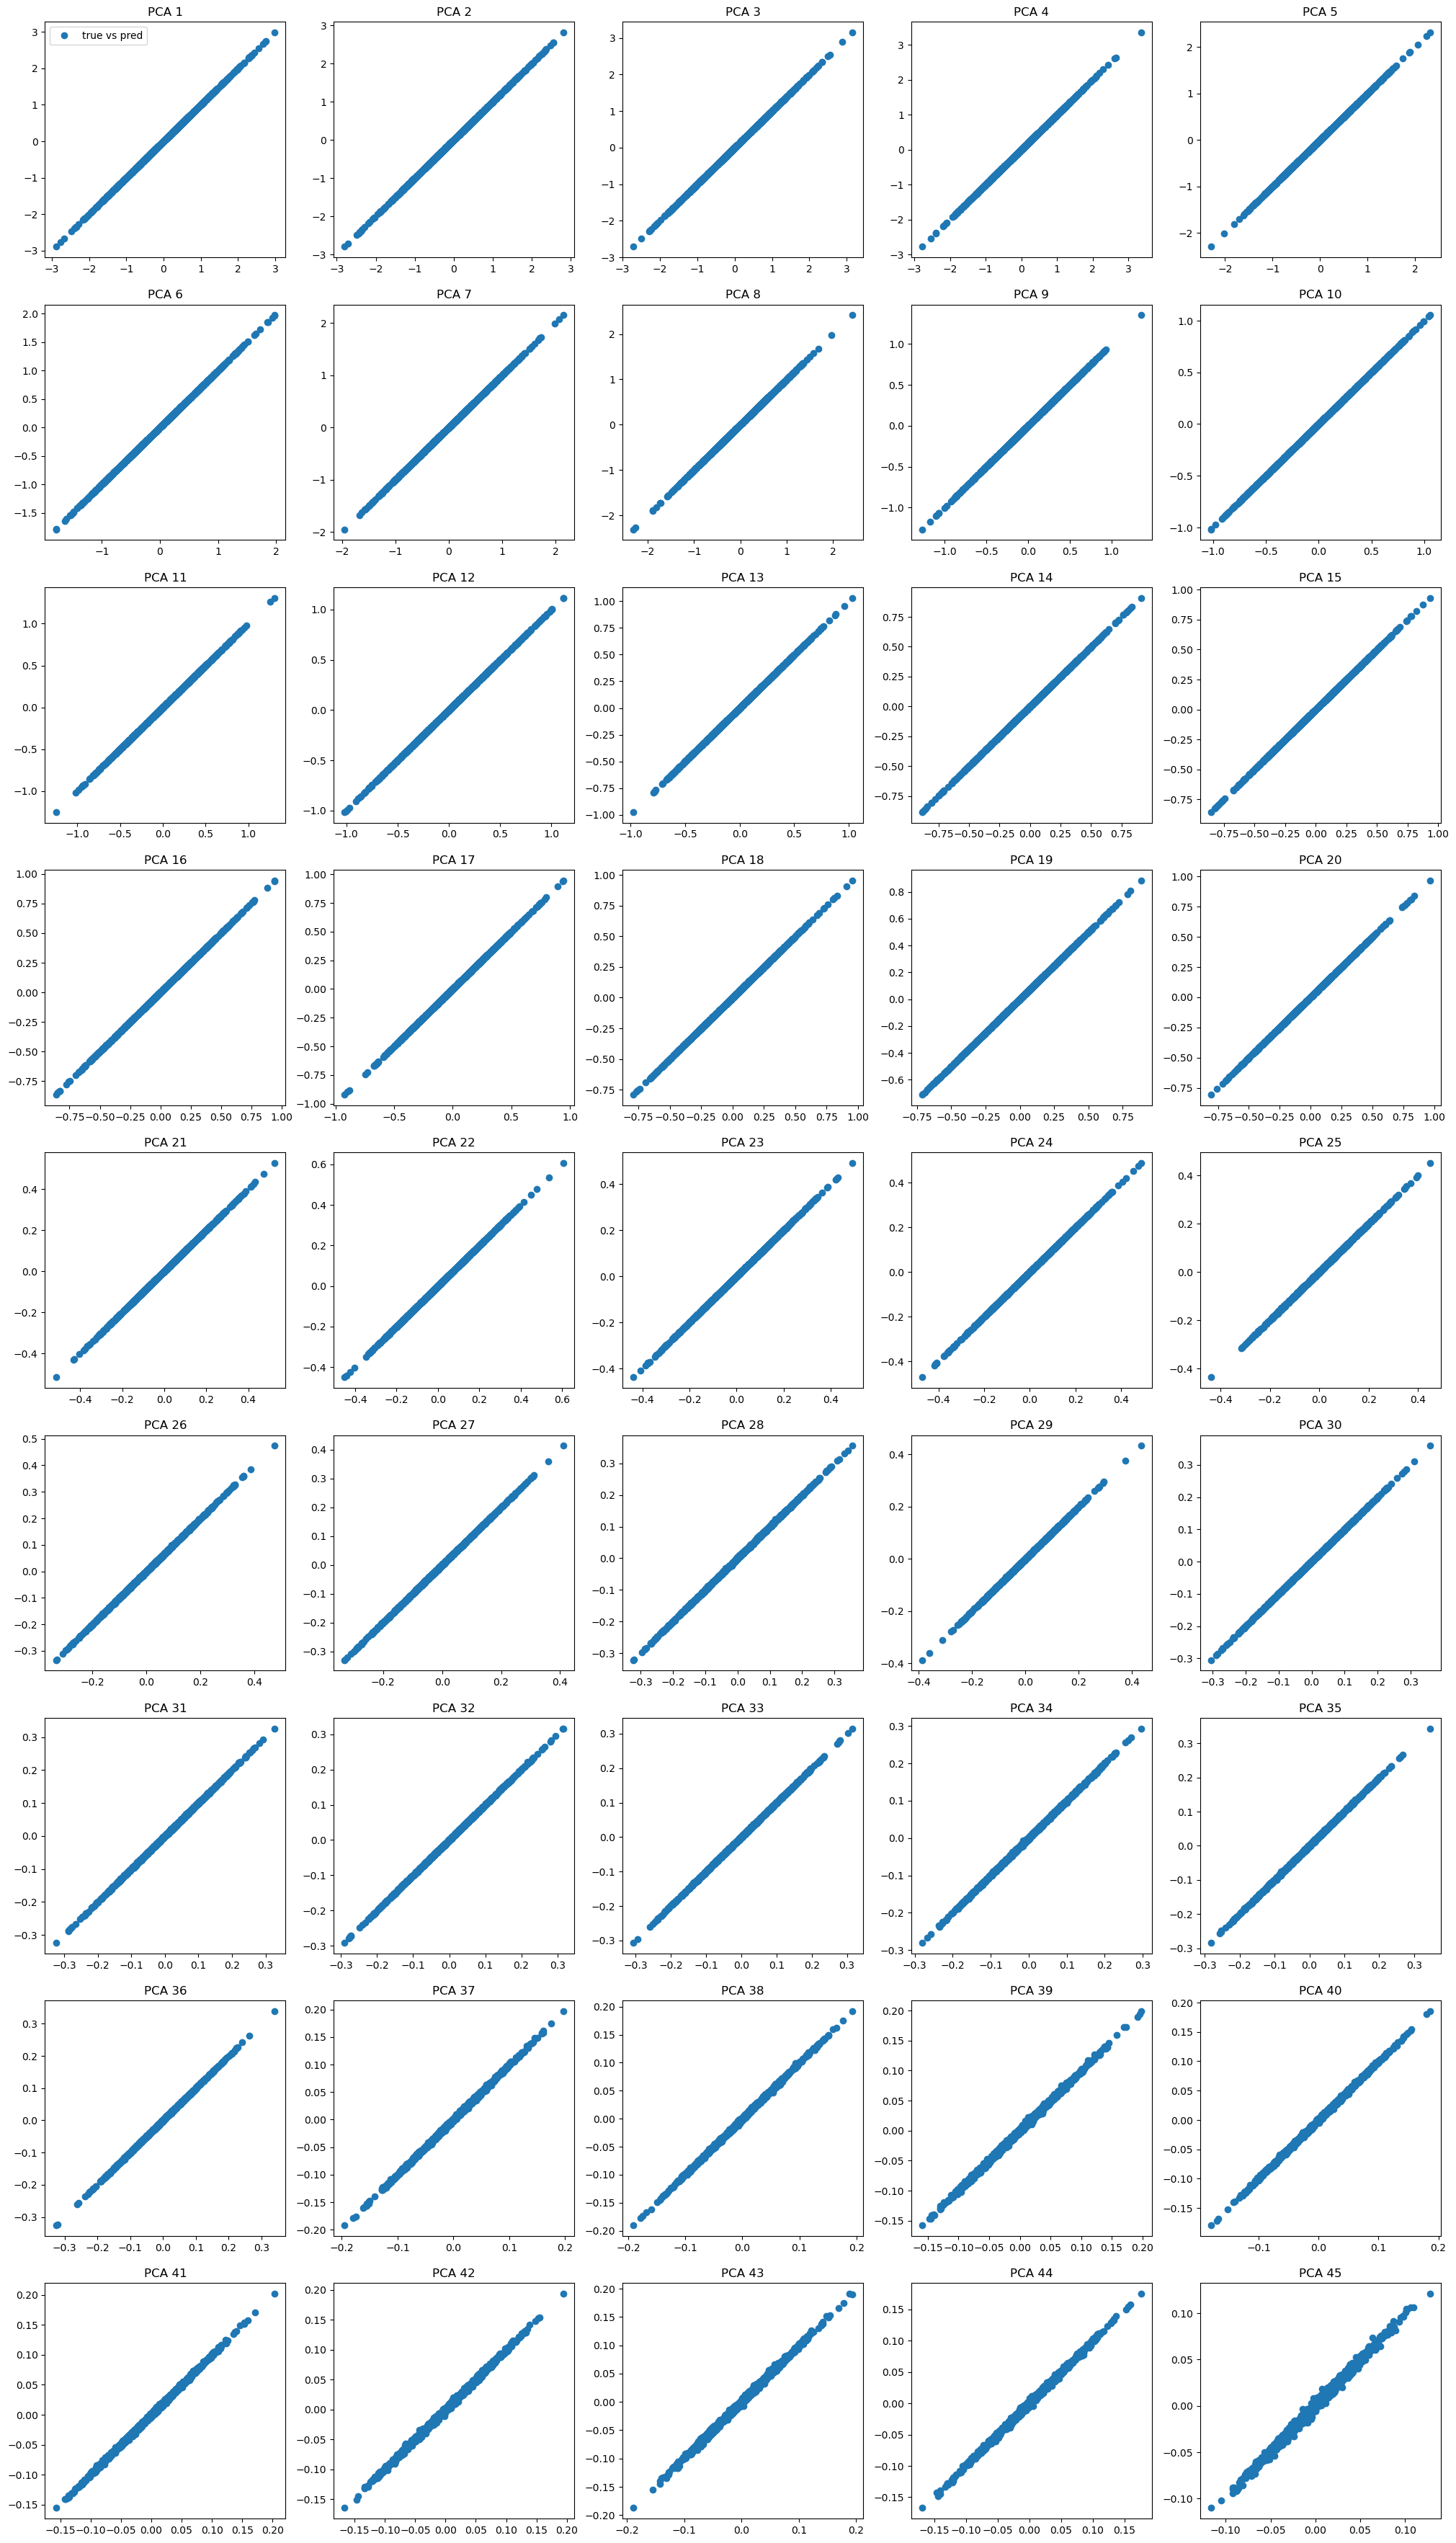

In [ ]:
x_train_pca = model.x_test_pca
y_train_pca = model.y_pca.transform(y_train)

fig, ax = plt.subplots(9, 5, figsize=(25, 45))
ax = ax.flatten()

print(train_samples.shape)

for i in range(m):
    # ax[i].plot(x_train_pca[:, i], y_train_pca[:, i], 'o', label = 'true')
    # ax[i].plot(x_train_pca[:, i][np.argsort(x_train_pca[:, i])], model.y_pred_pca[:, 0, i][np.argsort(x_train_pca[:, i])], '-', label = 'pred', lw = 4)
    # for j in range(n_samples):
    #     train_samples_pca_j = train_samples[:, :, j]
    #     train_samples_j = model.y_pca.transform(train_samples_pca_j)
    #     ax[i].plot(x_train_pca[:, i][np.argsort(x_train_pca[:, i])], train_samples_j[:, i][np.argsort(train_samples_j[:, i])], '-', label = f'sample {j+1}')
    ax[i].plot(y_train_pca[:, i], model.y_pred_pca[:, 0, i], 'o', label = 'true vs pred')
    ax[i].set_title(f'PCA {i+1}')
ax[0].legend()
plt.show()

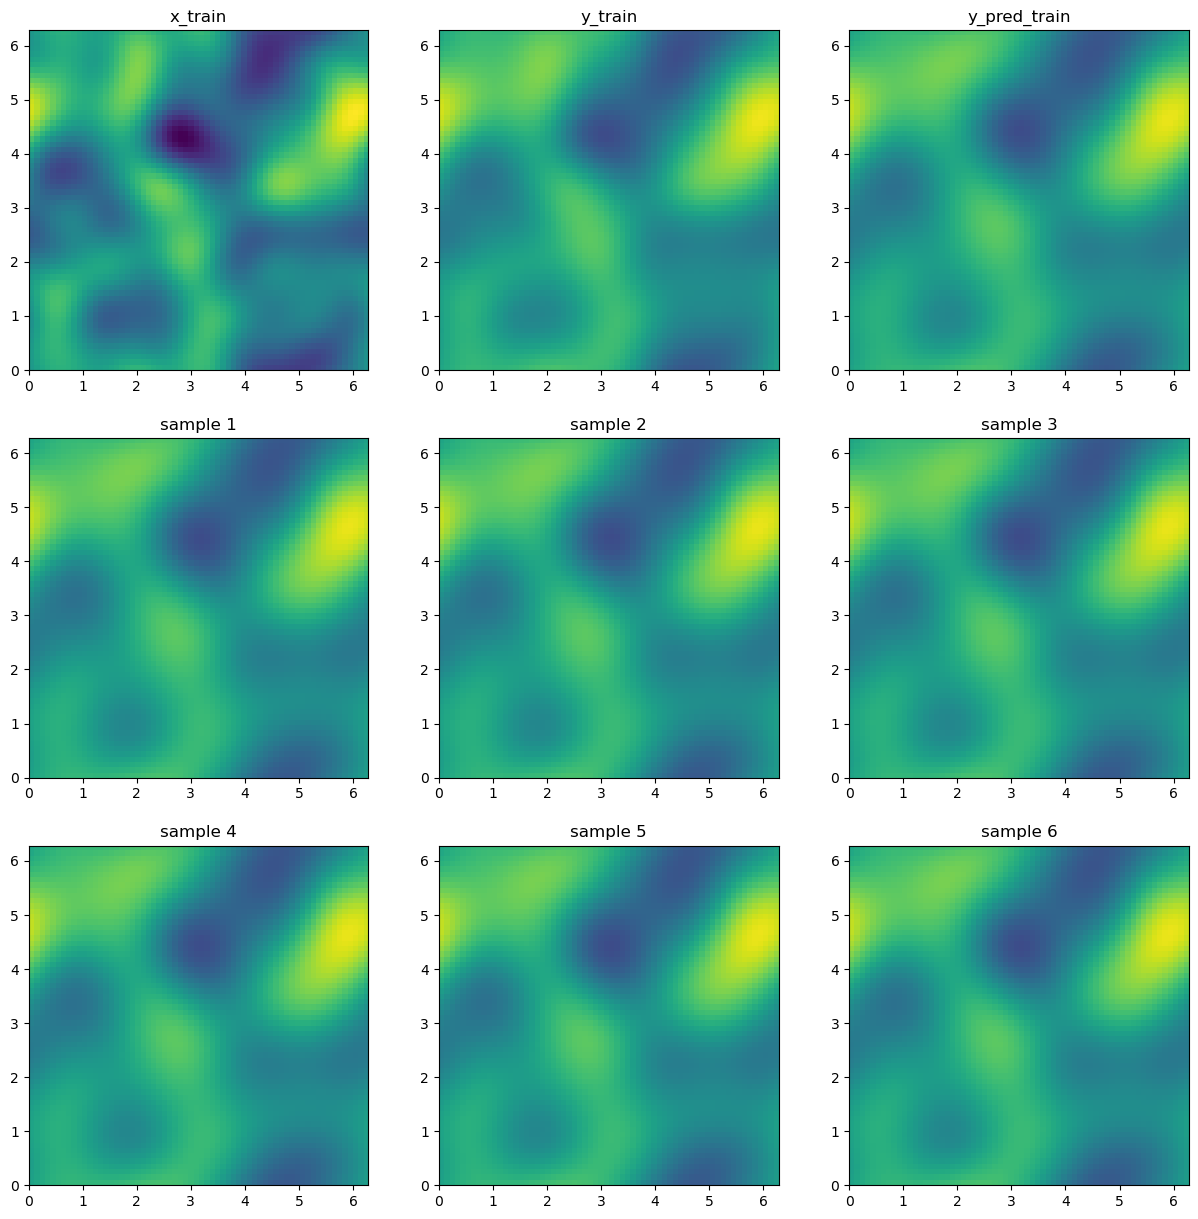

In [ ]:
index_to_plot = 127

y_lims = np.array([min(y_test[index_to_plot, :].min(), y_pred_train[index_to_plot, :].min()), max(y_test[index_to_plot, :].max(), y_pred_train[index_to_plot, :].max())])

fig, ax = plt.subplots(3, 3, figsize = (15, 15))
ax = ax.flatten()
im0 = ax[0].imshow(x_train[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi])
ax[0].set_title("x_train")
im1 = ax[1].imshow(y_train[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
ax[1].set_title("y_train")
im2 = ax[2].imshow(y_pred_train[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
ax[2].set_title("y_pred_train")
for i in range(6):
    imi = ax[i+3].imshow(train_samples[index_to_plot, :, i].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
    ax[i+3].set_title(f"sample {i+1}")
    
            # ax[i].legend()
plt.show()

# testing

In [ ]:
n_samples = 100

y_pred_test, test_samples = model.predict(x_test, n_samples = n_samples)

relative_L2 = np.linalg.norm(y_pred_test - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1)

print(f'median relative L2: {np.median(relative_L2)}')
print(f'mean relative L2: {np.mean(relative_L2)}')

100%|██████████| 45/45 [01:28<00:00,  1.96s/it]


median relative L2: 0.07698454332179043
mean relative L2: 0.07906674396623316


(1000, 4096, 6)


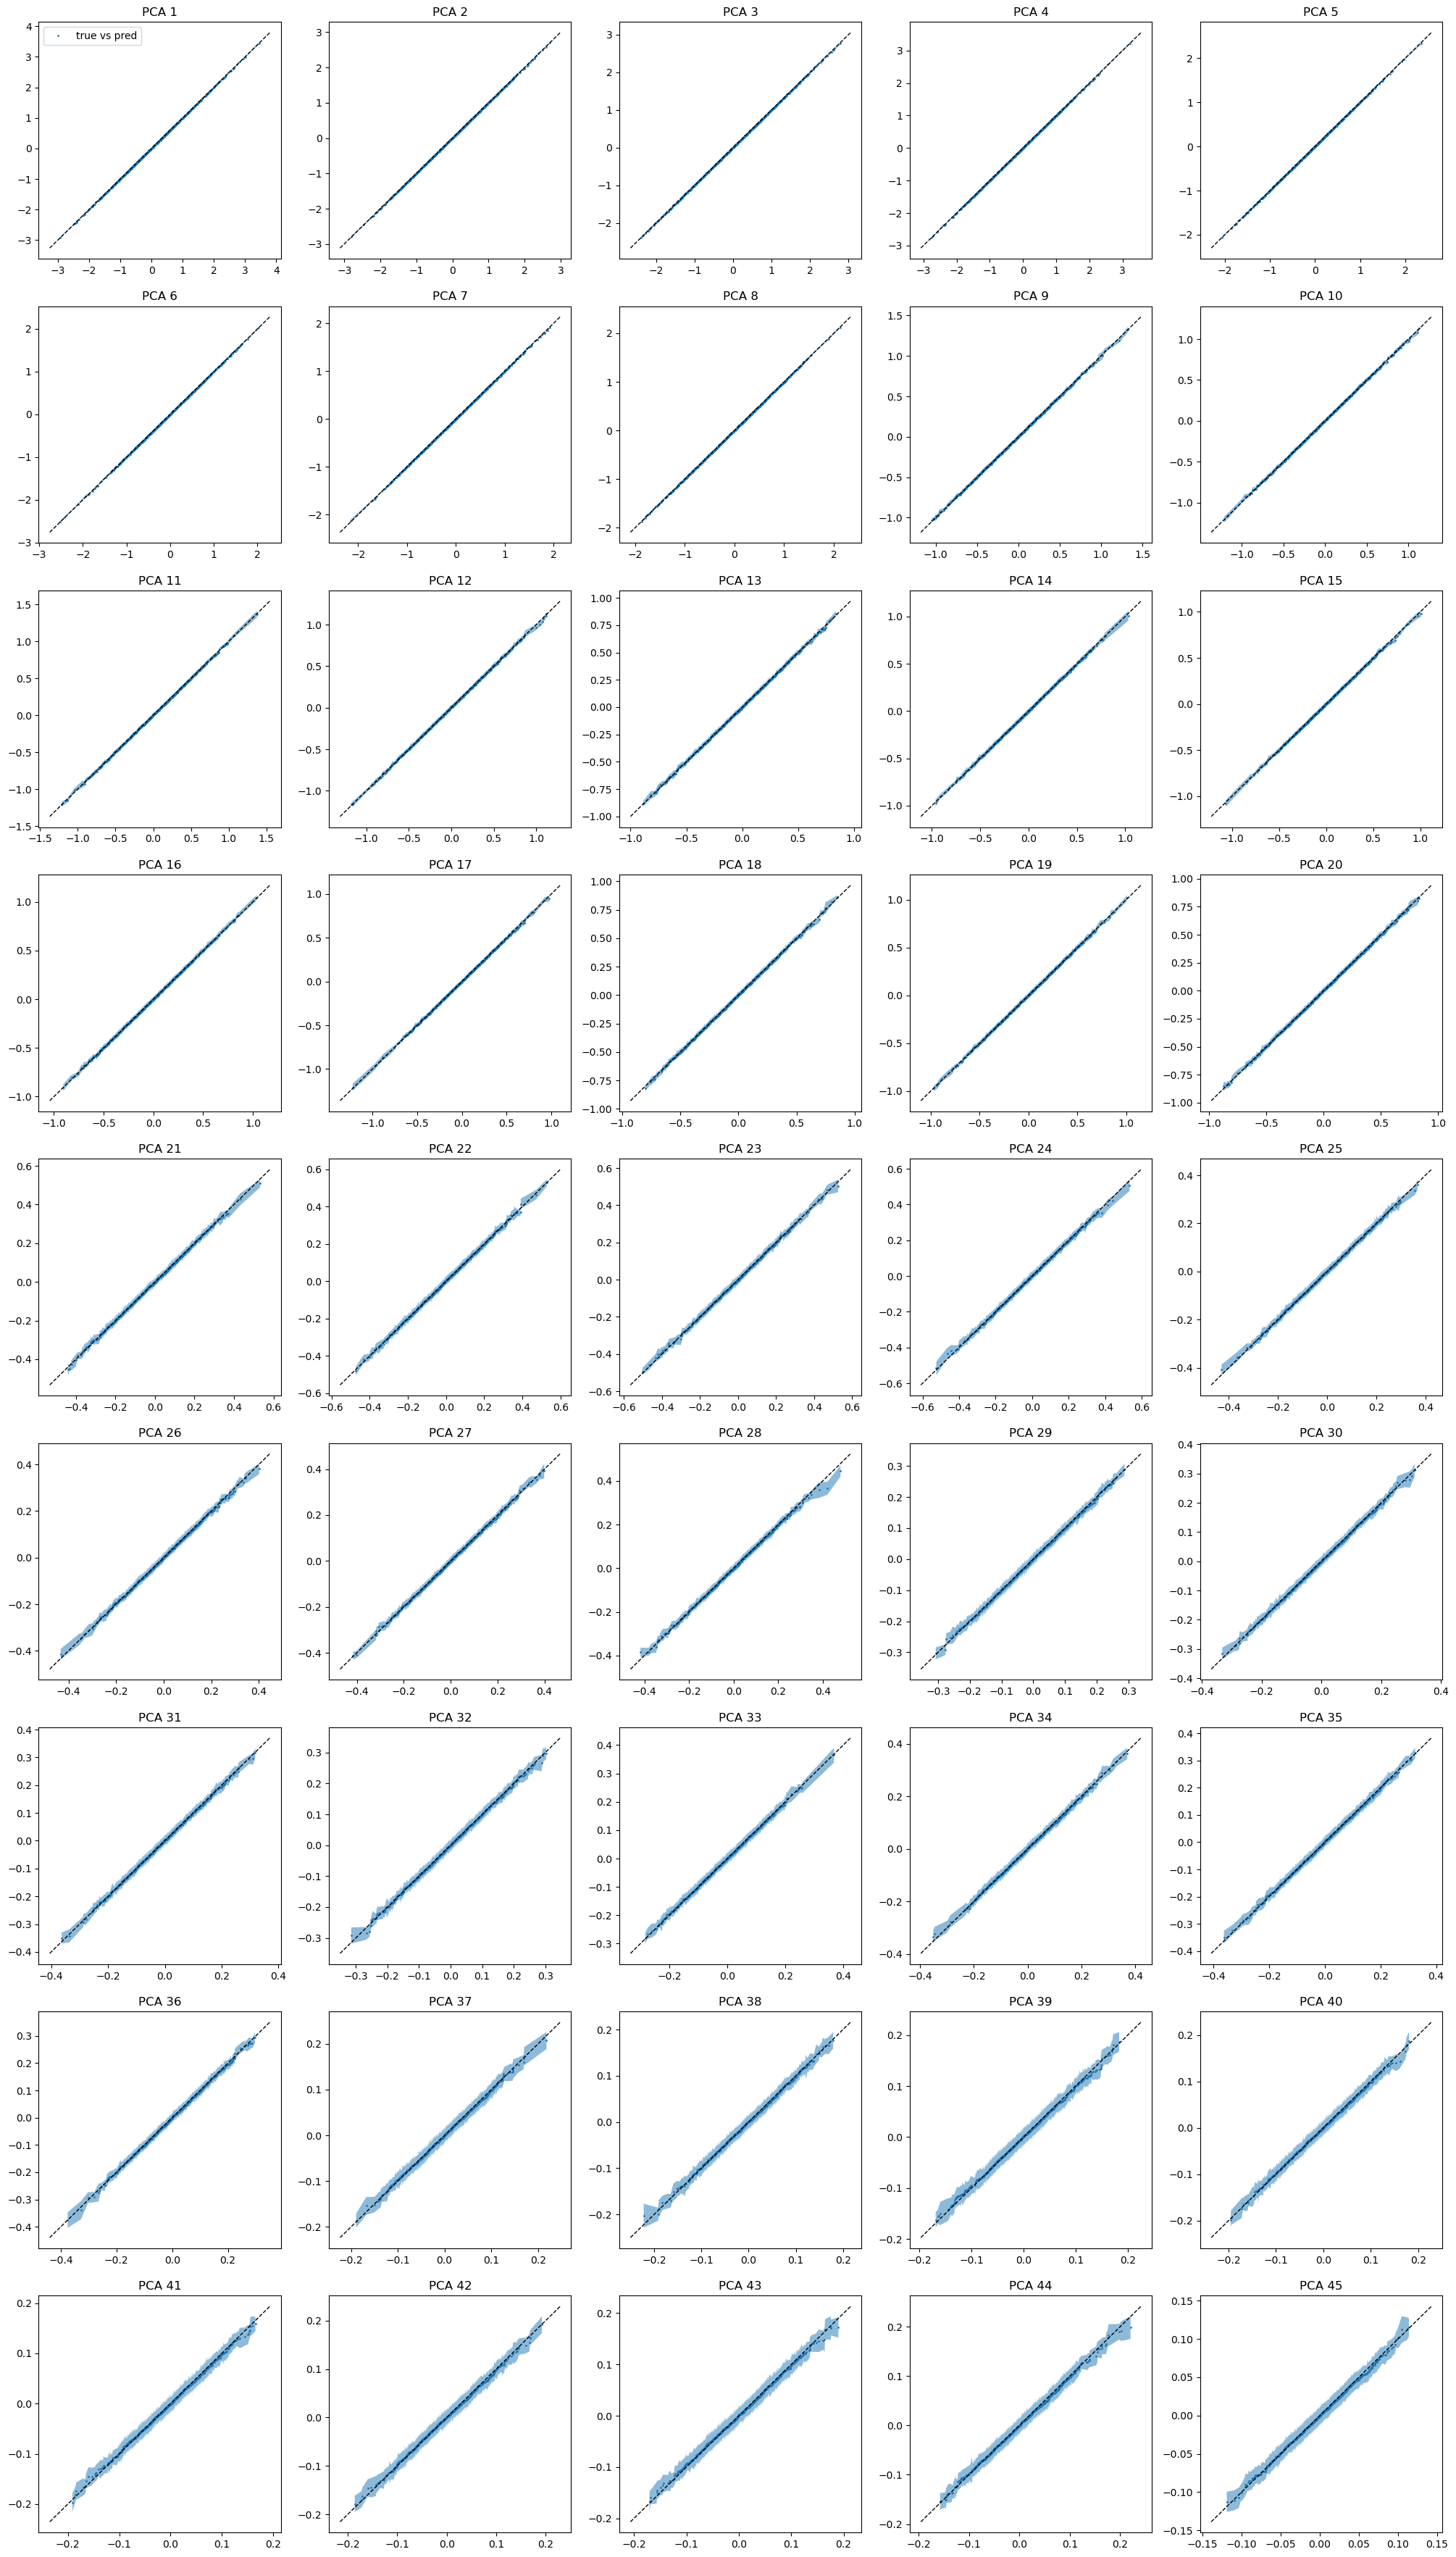

In [ ]:
x_test_pca = model.x_test_pca
y_test_pca = model.y_pca.transform(y_test)

fig, ax = plt.subplots(9, 5, figsize=(25, 45))
ax = ax.flatten()

print(train_samples.shape)

for i in range(m):
    # ax[i].plot(x_train_pca[:, i], y_train_pca[:, i], 'o', label = 'true')
    # ax[i].plot(x_train_pca[:, i][np.argsort(x_train_pca[:, i])], model.y_pred_pca[:, 0, i][np.argsort(x_train_pca[:, i])], '-', label = 'pred', lw = 4)
    # for j in range(n_samples):
    #     train_samples_pca_j = train_samples[:, :, j]
    #     train_samples_j = model.y_pca.transform(train_samples_pca_j)
    #     ax[i].plot(x_train_pca[:, i][np.argsort(x_train_pca[:, i])], train_samples_j[:, i][np.argsort(train_samples_j[:, i])], '-', label = f'sample {j+1}')
    ax[i].plot(y_test_pca[:, i][np.argsort(y_test_pca[:, i])], model.y_pred_pca[:, 0, i][np.argsort(model.y_pred_pca[:, 0, i])], 'o', label = 'true vs pred', ms = 1)
    ax[i].fill_between(y_test_pca[:, i][np.argsort(y_test_pca[:, i])], model.y_pred_pca[:, 1, i][np.argsort(model.y_pred_pca[:, 0, i])], model.y_pred_pca[:, 2, i][np.argsort(model.y_pred_pca[:, 0, i])], alpha = 0.5)
    # ax[i].plot(y_test_pca[:, i], model.y_pred_pca[:, 1, i], 'o', label = r'true vs (pred - 2$\sigma$)')
    # ax[i].plot(y_test_pca[:, i], model.y_pred_pca[:, 2, i], 'o', label = r'true vs (pred + 2$\sigma$)')
    xlim = ax[i].get_xlim()
    ylim = ax[i].get_ylim()

    min_val = min(xlim[0], ylim[0])
    max_val = max(xlim[1], ylim[1])

    ax[i].plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)
    ax[i].set_title(f'PCA {i+1}')
ax[0].legend()
plt.show()

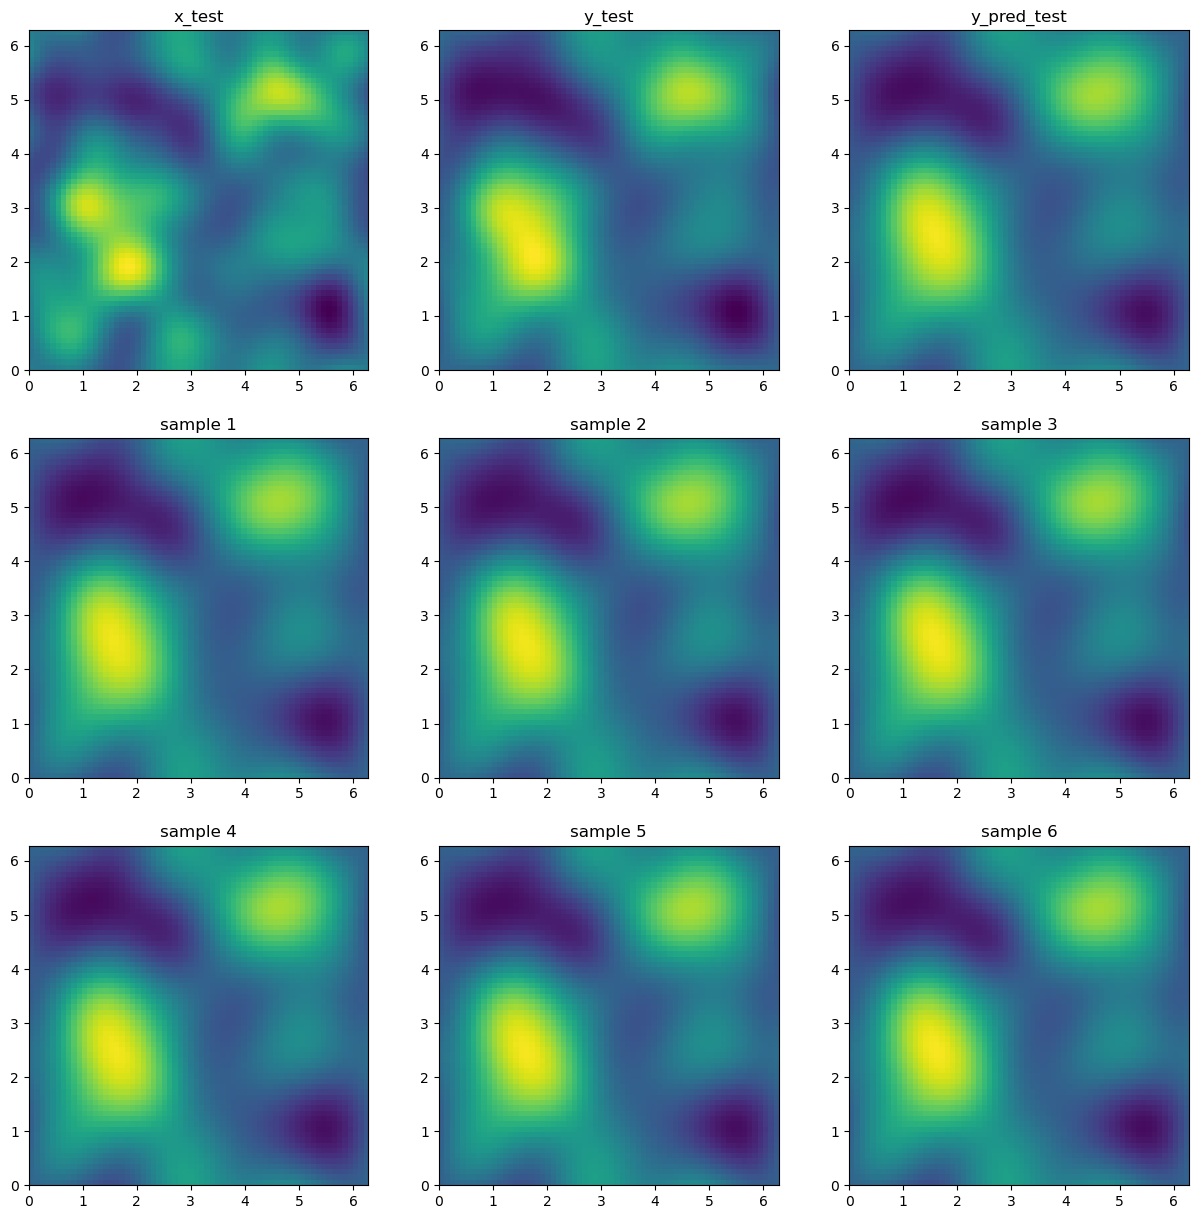

In [ ]:
index_to_plot = 125

y_lims = np.array([min(y_test[index_to_plot, :].min(), y_pred_test[index_to_plot, :].min()), max(y_test[index_to_plot, :].max(), y_pred_test[index_to_plot, :].max())])

fig, ax = plt.subplots(3, 3, figsize = (15, 15))
ax = ax.flatten()
im0 = ax[0].imshow(x_test[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi])
ax[0].set_title("x_test")
im1 = ax[1].imshow(y_test[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
ax[1].set_title("y_test")
im2 = ax[2].imshow(y_pred_test[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
ax[2].set_title("y_pred_test")
for i in range(6):
    imi = ax[i+3].imshow(test_samples[index_to_plot, :, i].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
    ax[i+3].set_title(f"sample {i+1}")
    
            # ax[i].legend()
plt.show()

## analyse uncertainty

In [ ]:
print(test_samples.shape)

test_samples_mean = np.mean(test_samples, axis = 2)
test_samples_std = np.std(test_samples, axis = 2)

(1000, 4096, 100)


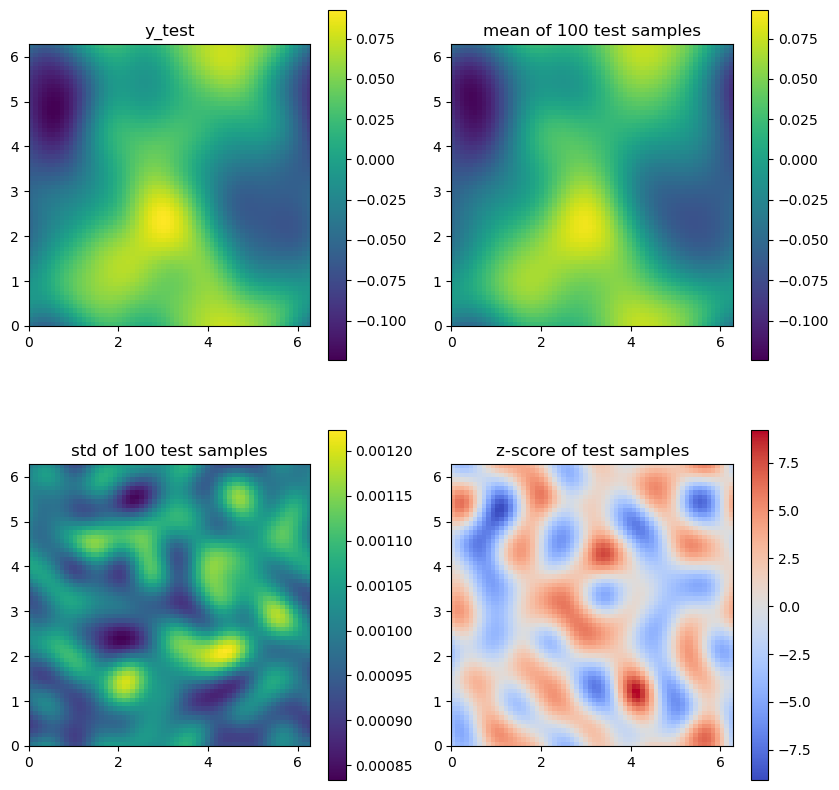

In [ ]:
index_to_plot = 126

y_lims = np.array([min(y_test[index_to_plot, :].min(), test_samples_mean[index_to_plot, :].min()), max(y_test[index_to_plot, :].max(), test_samples_mean[index_to_plot, :].max())])

fig, ax = plt.subplots(2, 2, figsize = (10, 10))
ax = ax.flatten()

im0 = ax[0].imshow(y_test[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
ax[0].set_title("y_test")
im1 = ax[1].imshow(test_samples_mean[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
ax[1].set_title(f"mean of {n_samples} test samples")
im2 = ax[2].imshow(test_samples_std[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi])
ax[2].set_title(f"std of {n_samples} test samples")
im3 = ax[3].imshow((y_test[index_to_plot, :].reshape(64, 64) - test_samples_mean[index_to_plot, :].reshape(64, 64)) / test_samples_std[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], cmap = 'coolwarm')
ax[3].set_title(f"z-score of test samples")
fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])
fig.colorbar(im2, ax=ax[2])
fig.colorbar(im3, ax=ax[3])


Linear regression baseline

1000 128
0.05201441688534866 0.057826423417602926


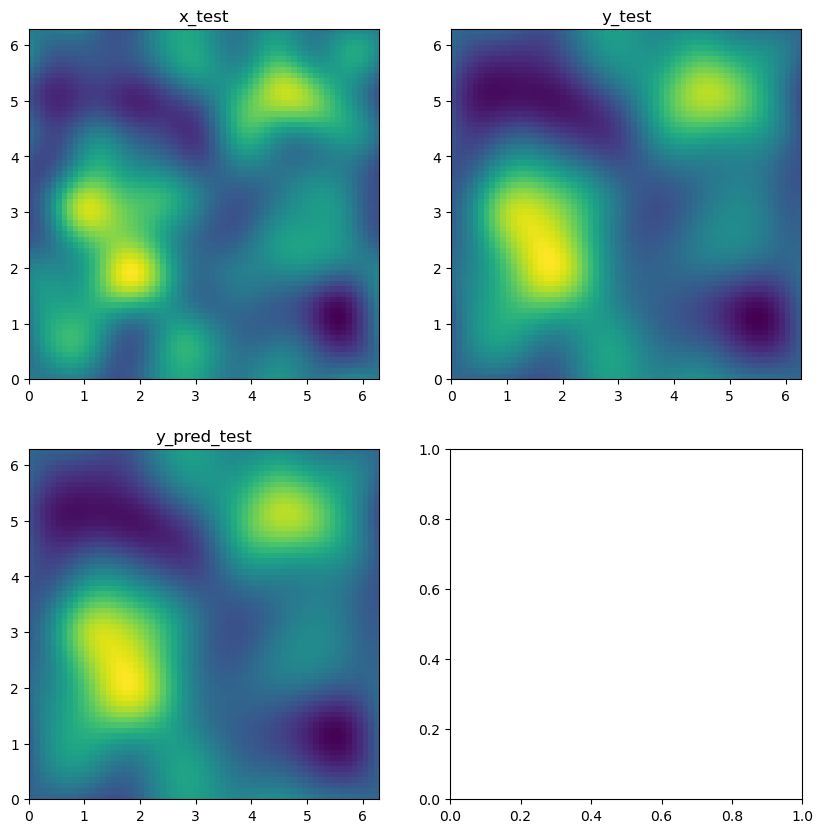

1000 256
0.052012760111377405 0.057827641758935414


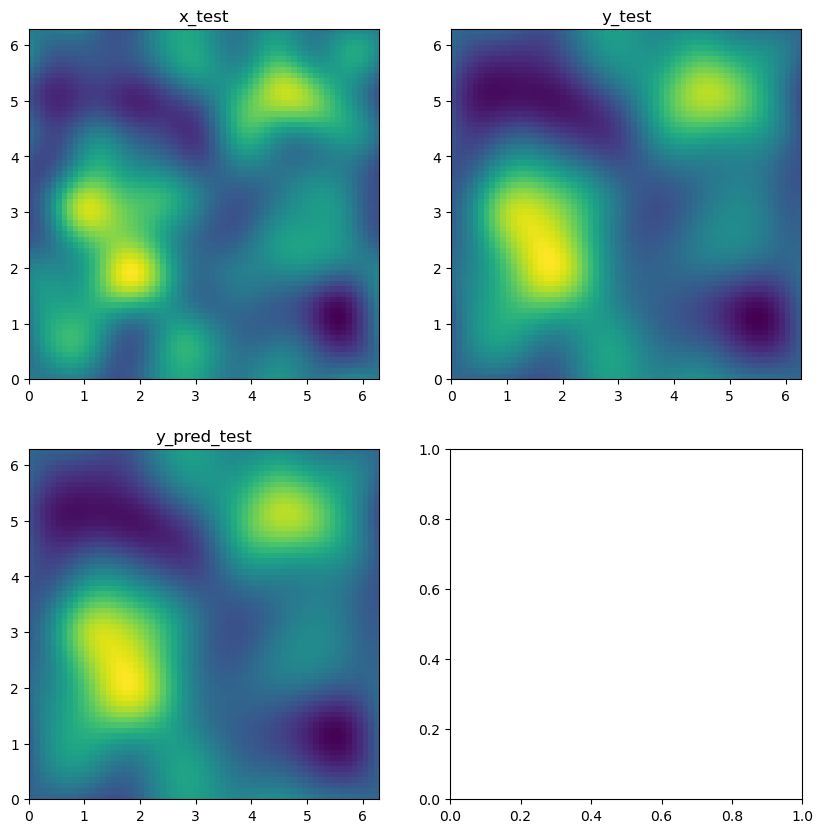

1000 512
0.05201354212616863 0.05782475359456119


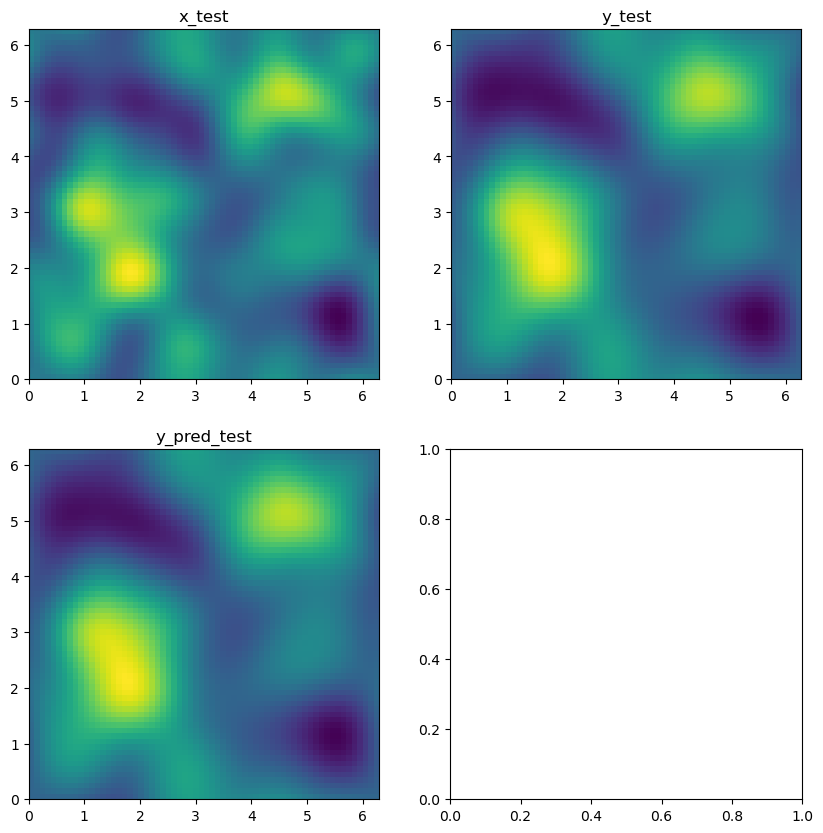

1000 1024
0.051470239119434616 0.0588309934177186


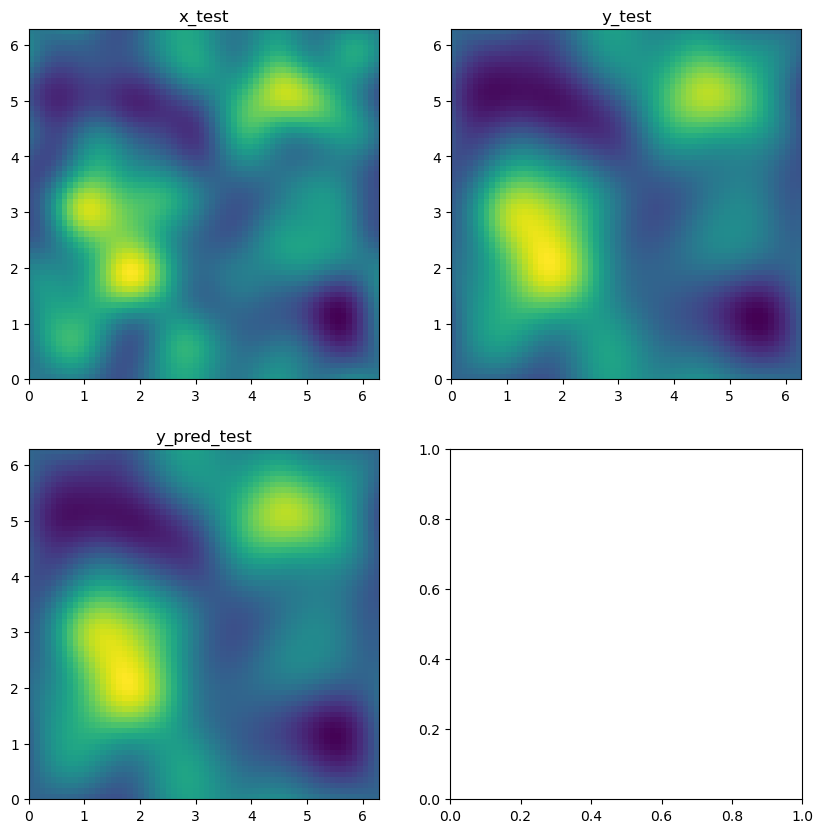

In [ ]:
results = []
for Ntrain in [1000]:
    for N_components in [128, 256, 512, 1024]:
        print(Ntrain, N_components)
        Ytr = y_train
        Xtr = x_train
        pca = PCA(n_components=min(N_components,Ntrain))
        Xtr = pca.fit_transform(Xtr)
        reg = LinearRegression(n_jobs = -1).fit(Xtr, Ytr)
        #Ypred Ypredtr = reg.predict(Xtr)
        Ypredtr = reg.predict(Xtr)
        train_error = np.mean(np.linalg.norm(Ypredtr-Ytr, axis = 1)/np.linalg.norm(Ytr, axis = 1))
        Xtest = x_test
        Ytest = y_test
        Xtest = pca.transform(Xtest)
        Ypred = reg.predict(Xtest)
        test_error = np.mean(np.linalg.norm(Ypred-Ytest, axis = 1)/np.linalg.norm(Ytest, axis = 1))
        print(train_error, test_error)
        results.append([Ntrain, N_components, train_error, test_error])

        index_to_plot = 125

        y_lims = np.array([min(y_test[index_to_plot, :].min(), Ypred[index_to_plot, :].min()), max(y_test[index_to_plot, :].max(), Ypred[index_to_plot, :].max())])

        fig, ax = plt.subplots(2, 2, figsize = (10, 10))
        ax = ax.flatten()
        im0 = ax[0].imshow(x_test[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi])
        ax[0].set_title("x_test")
        im1 = ax[1].imshow(y_test[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
        ax[1].set_title("y_test")
        im2 = ax[2].imshow(Ypred[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
        ax[2].set_title("y_pred_test")
        plt.show()

results = np.array(results)